# 1. Simple LSTM Approach

## 1.1 Import of packages, dataset and decision point map

In [2]:
# Add FINAL/code to sys.path to import custom functions
import sys
import os
code_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "code"))
sys.path.insert(0, code_dir)

# ── Standard Library ─────────────────────────────────────────────
import os
import importlib
import re
from pathlib import Path

# ── Data & Visualization ─────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ── Third-Party Libraries ────────────────────────────────────────
import joblib
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# PM4Py (BPMN handling)
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.conversion.bpmn.variants import to_petri_net

# ── Local Modules ────────────────────────────────────────────────
from preprocess import extract_bpmn_decision_point_map
from train import (
    prepare_sequences_and_labels,
    prepare_context_attributes,
    build_lstm_model,
    train_model
)
from evaluate import (
    evaluate_baseline,
    compare_f1_for_trained_model,
    add_unknown_label,
    permutation_importance_context,
    permutation_importance_all_features,
    plot_feature_importance
)

In [3]:
# Import BPMN-File
bpmn_model = bpmn_importer.apply("../resources/loan_application.bpmn")

# Convert BPMN to Petri net
net, im, fm = to_petri_net.apply(bpmn_model)

bpmn_decision_point_map = extract_bpmn_decision_point_map(bpmn_model)

In [4]:
# Path relative to current working directory
path = "../data/processed/dp_split_datasets_full_simple.joblib"

dp_split_datasets_full_simple = joblib.load(path)

print("Loaded type:", type(dp_split_datasets_full_simple))
print("Top-level keys:", list(dp_split_datasets_full_simple.keys())[:5])

Loaded type: <class 'dict'>
Top-level keys: ['DP 1', 'DP 3', 'DP 4', 'DP 5', 'DP 7']


## 1.2 Training for each decision point and prediction on holdout dataset

In [ ]:
# ----- CONFIG -----
TARGET_DECISION_POINT = "DP 7"  # e.g., "DP4"
context_keys = ["case:LoanGoal", "case:ApplicationType", "case:RequestedAmount"]

# ----- REQUIRED OBJECTS CHECKS -----
required_vars = ["dp_split_datasets_full_simple"]
required_funcs = ["prepare_sequences_and_labels", "prepare_context_attributes", "build_lstm_model"]
missing_vars = [v for v in required_vars if v not in globals()]
missing_funcs = [f for f in required_funcs if f not in globals() or not callable(globals()[f])]

if missing_vars or missing_funcs:
    raise RuntimeError(
        "Missing dependencies:\n"
        f"- Vars missing: {missing_vars}\n"
        f"- Funcs missing or not callable: {missing_funcs}\n"
        "Ensure these are defined in the environment."
    )

# ----- FETCH SPLITS FOR TARGET DECISION POINT -----
all_dps = list(dp_split_datasets_full_simple.keys())
if TARGET_DECISION_POINT not in dp_split_datasets_full_simple:
    raise ValueError(
        f"Decision point '{TARGET_DECISION_POINT}' not found. "
        f"Available: {all_dps}"
    )

splits = dp_split_datasets_full_simple[TARGET_DECISION_POINT]
df_train = splits["train"]
df_test = splits["test"]
df_holdout = splits["holdout"]

# Pool train+test as training pool if that mirrors your prior setup
df_train_pool = pd.concat([df_train, df_test], ignore_index=True)
n_pool = len(df_train_pool)

# --- Prepare data for sequence model ---
df_lstm = pd.concat([df_train_pool, df_holdout], ignore_index=True)

(
    X_acts_padded,
    X_durs_padded,
    X_res_padded,
    activity_encoder,
    resource_encoder,
    label_encoder,
    y_all,
    max_seq_len,
) = prepare_sequences_and_labels(df_lstm)

# Ensure "UNKNOWN" present in encoders if your pipeline expects it
if "UNKNOWN" not in getattr(resource_encoder, "classes_", []):
    resource_encoder.classes_ = np.append(resource_encoder.classes_, "UNKNOWN")
if "UNKNOWN" not in getattr(activity_encoder, "classes_", []):
    activity_encoder.classes_ = np.append(activity_encoder.classes_, "UNKNOWN")

# Context features
X_context_array, context_dim, context_encoders = prepare_context_attributes(df_lstm, context_keys)

# Indices: first n_pool rows are train (train+test pool), remaining are holdout
train_indices = list(range(0, n_pool))
test_indices = list(range(n_pool, n_pool + len(df_holdout)))

X_acts_train, X_acts_test = X_acts_padded[train_indices], X_acts_padded[test_indices]
X_durs_train, X_durs_test = X_durs_padded[train_indices], X_durs_padded[test_indices]
X_res_train,  X_res_test  = X_res_padded[train_indices],  X_res_padded[test_indices]
X_context_train, X_context_test = X_context_array[train_indices], X_context_array[test_indices]
y_train, y_test = y_all[train_indices], y_all[test_indices]

# --- Build model ---
num_activities = len(activity_encoder.classes_)
num_resources  = len(resource_encoder.classes_)
num_classes    = len(label_encoder.classes_)

model = build_lstm_model(
    num_activities=num_activities,
    num_resources=num_resources,
    context_dim=context_dim,
    max_seq_len=max_seq_len,
    num_classes=num_classes,
)

# --- Train model (no saving, no reporting) ---
if "train_model" in globals() and callable(train_model):
    _ = train_model(
        model,
        X_train=[X_acts_train, X_durs_train, X_res_train, X_context_train],
        y_train=y_train,
    )
else:
    # Minimal fallback if train_model helper is absent
    model.fit(
        x=[X_acts_train, X_durs_train, X_res_train, X_context_train],
        y=y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
    )

# --- Print model summary only ---
print(f"\n=== Model summary for decision point: {TARGET_DECISION_POINT} ===")
model.summary(print_fn=lambda x: print(x))

Epoch 1/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7605 - loss: 0.5183 - val_accuracy: 0.8082 - val_loss: 0.3814
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8056 - loss: 0.3823 - val_accuracy: 0.8139 - val_loss: 0.3624
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.8092 - loss: 0.3671 - val_accuracy: 0.8106 - val_loss: 0.3730
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.

=== Model summary for decision point: DP 7 ===


Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ activity_input      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_input      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resource_input      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_embedding  │ (None, 15, 64)    │        576 │

In [4]:
# --- Storage ---
accuracy_per_class = []
baseline_accuracy_per_class = []
if "decision_point_models_simple" not in globals():
    decision_point_models_simple = {}

# --- Parameters ---
context_keys = ["case:LoanGoal", "case:ApplicationType", "case:RequestedAmount"]

# --- Loop through decision points ---
for decision_point in bpmn_decision_point_map:
    print(f"\n=== Training {decision_point} ===")

    try:
        # --- Load split datasets ---
        splits = dp_split_datasets_full_simple.get(decision_point)
        if not splits:
            print(f"No split data for {decision_point}")
            continue

        df_train = splits["train"]
        df_test = splits["test"]
        df_holdout = splits["holdout"]

        df_train_pool = pd.concat([df_train, df_test], ignore_index=True)
        n_pool = len(df_train_pool)

        # --- Prepare data ---
        df_lstm = pd.concat([df_train_pool, df_holdout], ignore_index=True)

        X_acts_padded, X_durs_padded, X_res_padded, activity_encoder, resource_encoder, label_encoder, y_all, max_seq_len = prepare_sequences_and_labels(df_lstm)

        # Add UNKNOWN class to encoders if missing
        if "UNKNOWN" not in resource_encoder.classes_:
            resource_encoder.classes_ = np.append(resource_encoder.classes_, "UNKNOWN")
        if "UNKNOWN" not in activity_encoder.classes_:
            activity_encoder.classes_ = np.append(activity_encoder.classes_, "UNKNOWN")

        # Prepare context attributes
        X_context_array, context_dim, context_encoders = prepare_context_attributes(df_lstm, context_keys)

        # Use train/test indexes to split padded input
        train_indices = list(range(0, n_pool))
        test_indices  = list(range(n_pool, n_pool + len(df_holdout)))

        X_acts_train, X_acts_test = X_acts_padded[train_indices], X_acts_padded[test_indices]
        X_durs_train, X_durs_test = X_durs_padded[train_indices], X_durs_padded[test_indices]
        X_res_train, X_res_test = X_res_padded[train_indices], X_res_padded[test_indices]
        X_context_train, X_context_test = X_context_array[train_indices], X_context_array[test_indices]
        y_train, y_test = y_all[train_indices], y_all[test_indices]

        # --- Build and train model ---
        model = build_lstm_model(
            num_activities=len(activity_encoder.classes_),
            num_resources=len(resource_encoder.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=len(label_encoder.classes_)
        )

        history = train_model(
            model,
            X_train=[X_acts_train, X_durs_train, X_res_train, X_context_train],
            y_train=y_train
        )

        # --- Evaluate ---
        y_pred_probs = model.predict([X_acts_test, X_durs_test, X_res_test, X_context_test])
        y_pred = np.argmax(y_pred_probs, axis=1)

        lstm_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_test, label_encoder)  # If using dist baseline now

        print(f"\n--- LSTM Model Results for {decision_point} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # Store results
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # Store trained model
        decision_point_models_simple[decision_point] = {
            "model": model,
            "activity_encoder": activity_encoder,
            "resource_encoder": resource_encoder,
            "label_encoder": label_encoder,
            "context_keys": context_keys,
            "context_encoders": context_encoders,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error while training {decision_point}: {e}")


=== Training DP 1 ===
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7915 - loss: 0.4851 - val_accuracy: 1.0000 - val_loss: 0.0556
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 0.0372 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step

--- LSTM Model Results for DP 1 ---
A_Concept: Precision=1.00, Recall=0.99, F1=1.00
A_Submitted: Precision=1.00, Recall=1.00, F1=1.00
W_Complete application: Precision=1.00, Recall=1.00, F1=1.00

=== Training DP 2 ===
No split data for DP 2

=== Training DP 3 ===
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9377 - lo

In [8]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)
df_baseline = pd.DataFrame(baseline_accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     86.563
Weighted Precision (Majority): 40.690
Relative Improvement:          112.74%

Weighted Recall (LSTM):        88.465
Weighted Recall (Majority):    40.639
Relative Improvement:          117.68%

Weighted F1 (LSTM):            86.554
Weighted F1 (Majority):        40.665
Relative Improvement:          112.85%


## 1.3 Comparison of Majority Predictor & LSTM per Decision Point on Holdout-Dataset

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step

Comparison for DP 1 (Holdout Set)
Weighted F1 (LSTM):     0.999
Weighted F1 (Baseline): 0.483
Relative Improvement:   106.70%


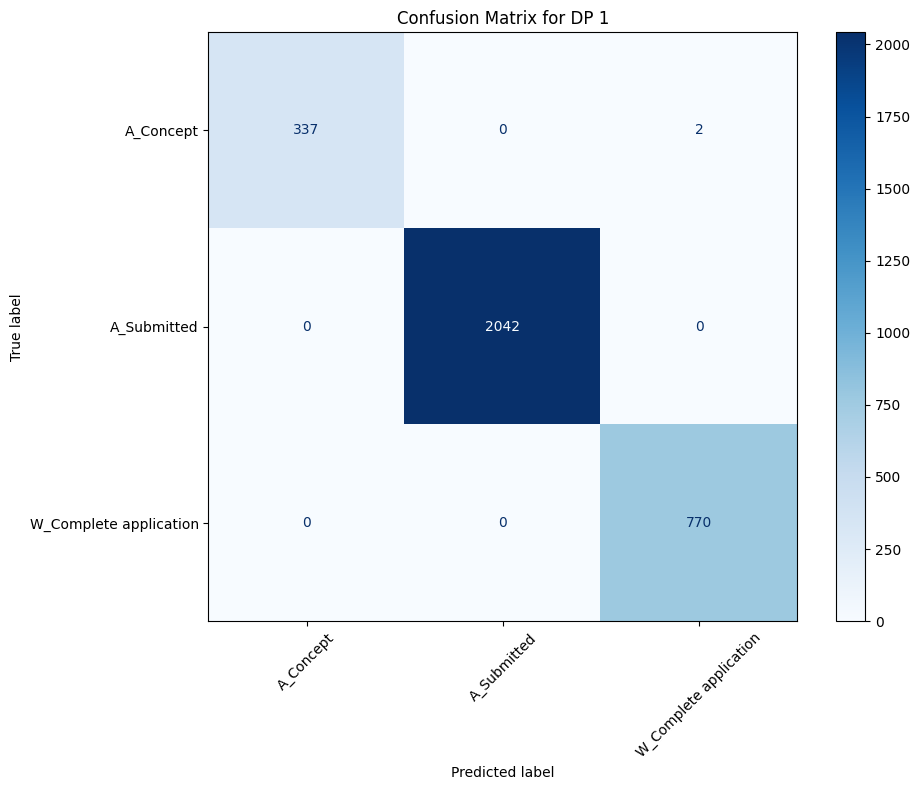

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 3 (Holdout Set)
Weighted F1 (LSTM):     0.976
Weighted F1 (Baseline): 0.511
Relative Improvement:   90.86%


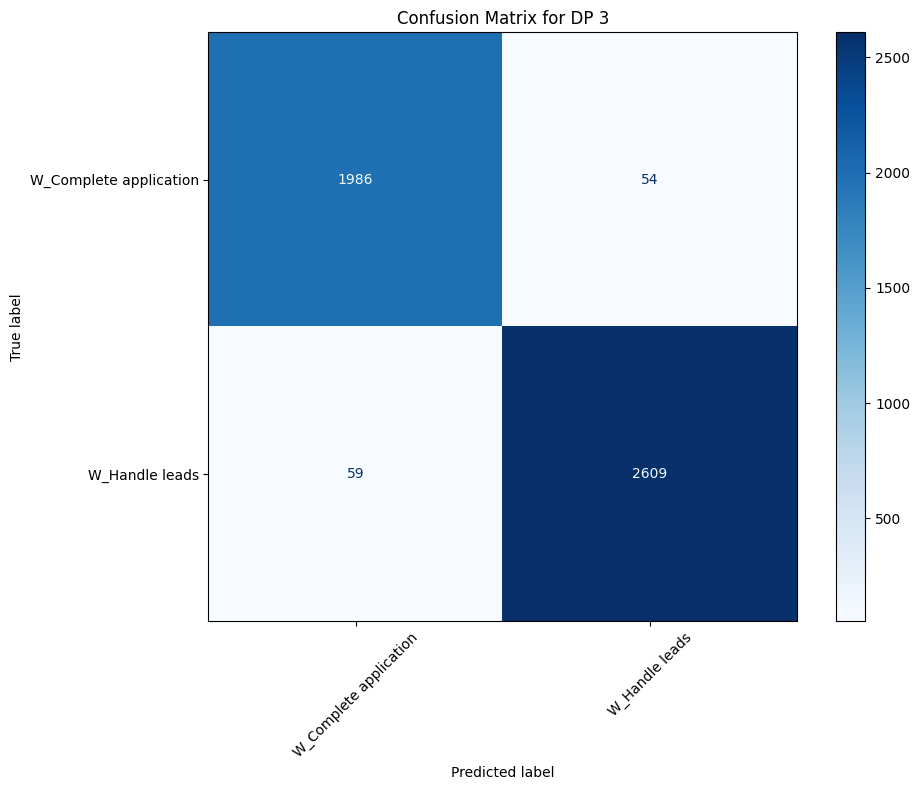

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Comparison for DP 4 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.809
Relative Improvement:   23.61%


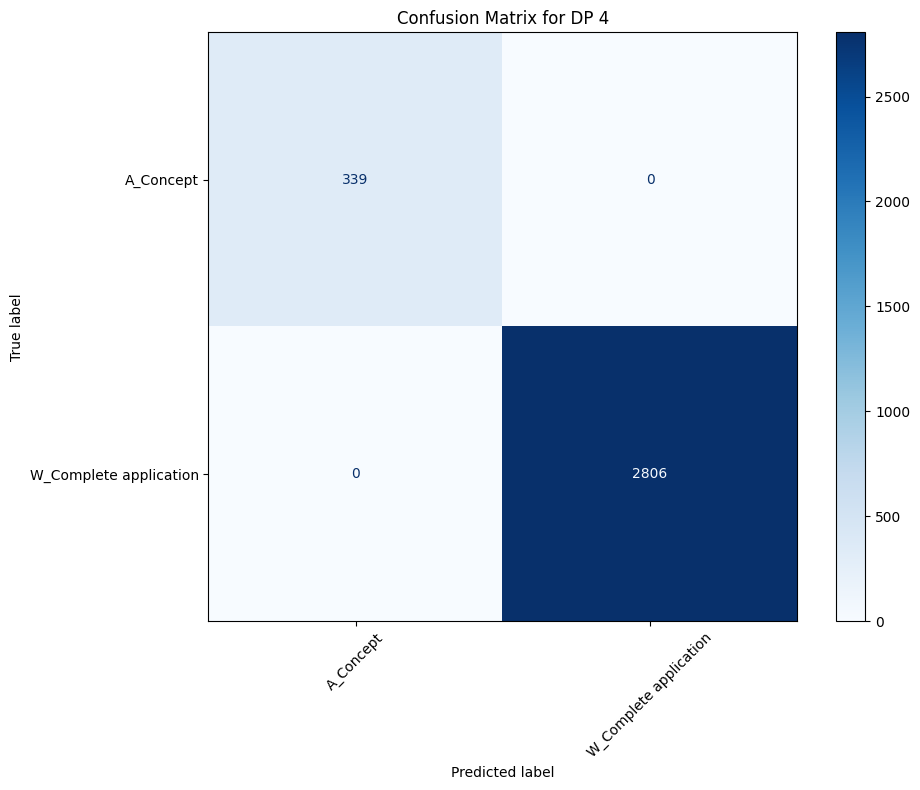

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Comparison for DP 5 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.809
Relative Improvement:   23.57%


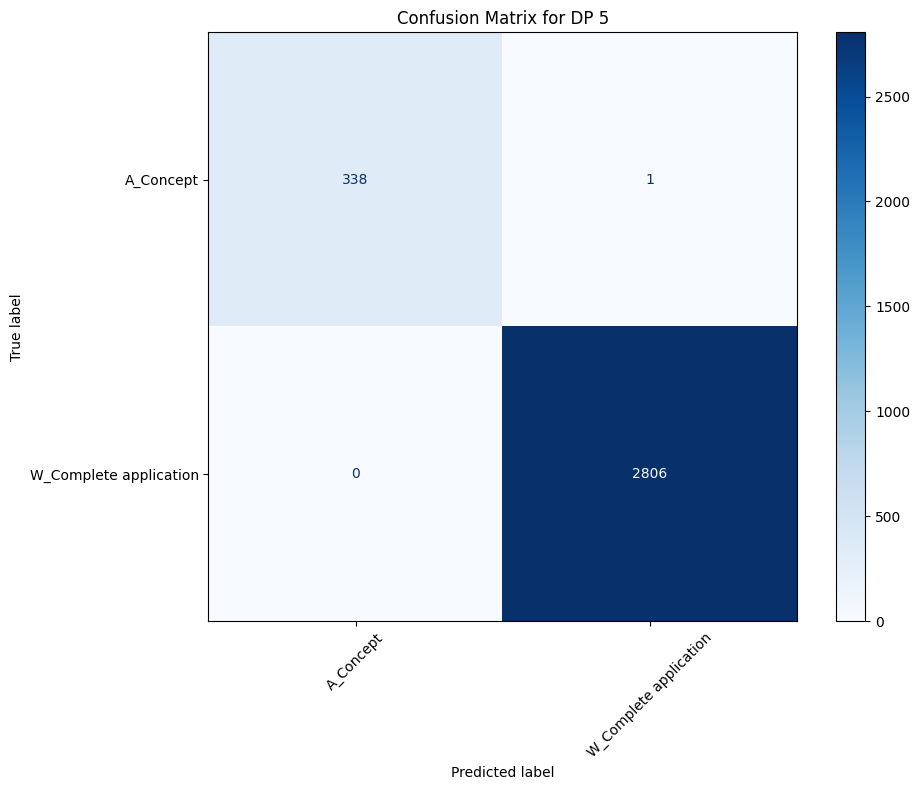

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 7 (Holdout Set)
Weighted F1 (LSTM):     0.768
Weighted F1 (Baseline): 0.394
Relative Improvement:   95.03%


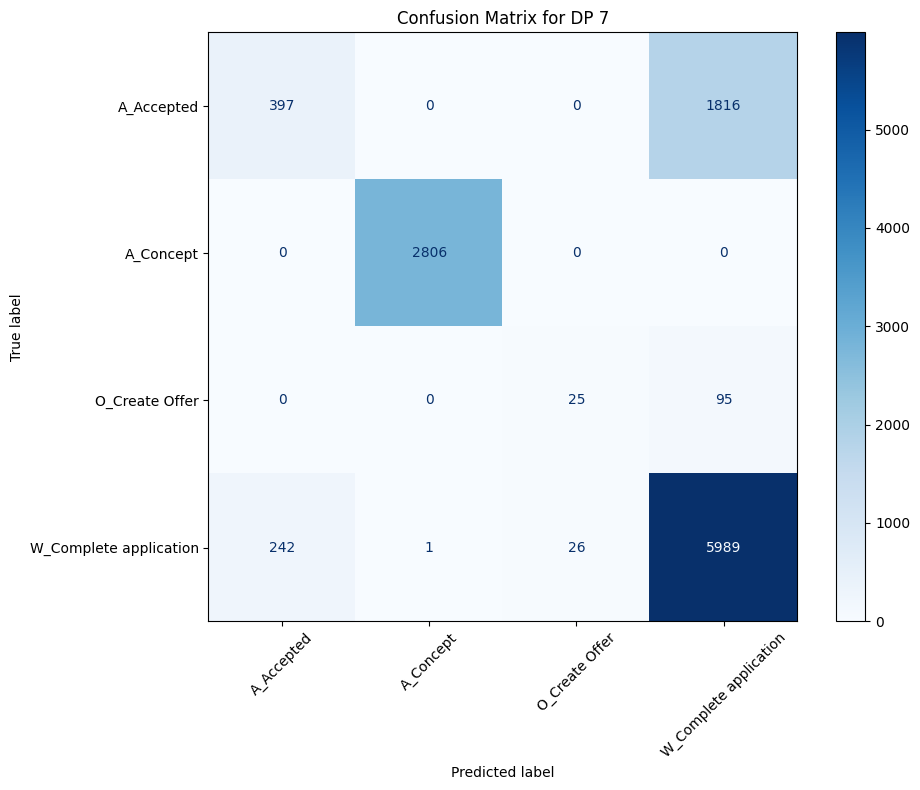

455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 8 (Holdout Set)
Weighted F1 (LSTM):     0.829
Weighted F1 (Baseline): 0.454
Relative Improvement:   82.53%


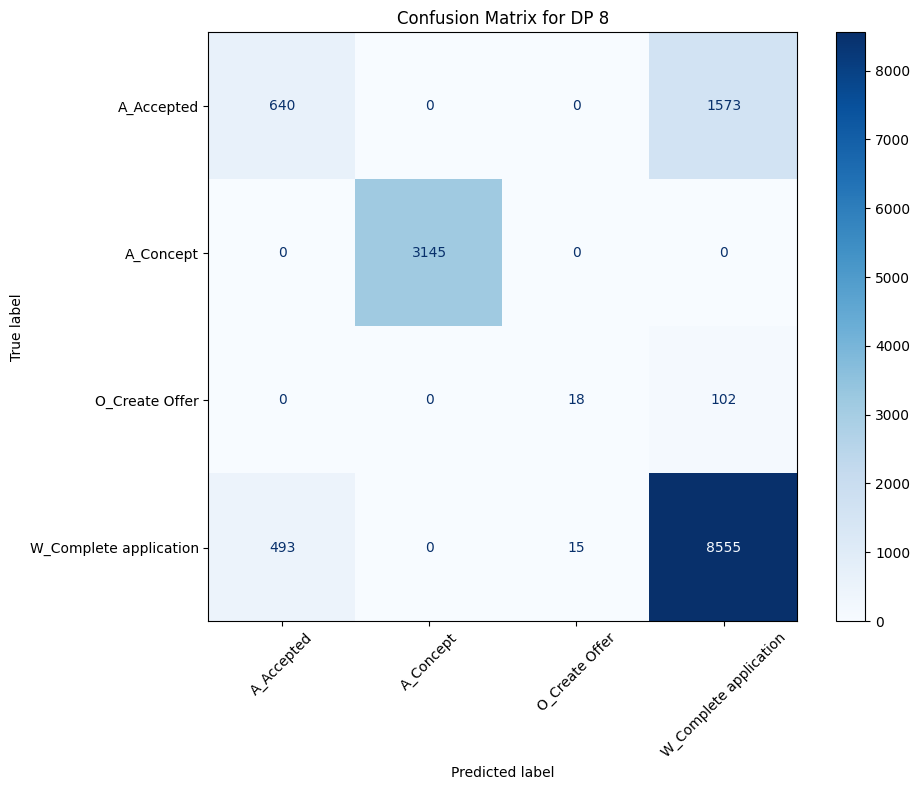

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 9 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.494
Relative Improvement:   73.94%


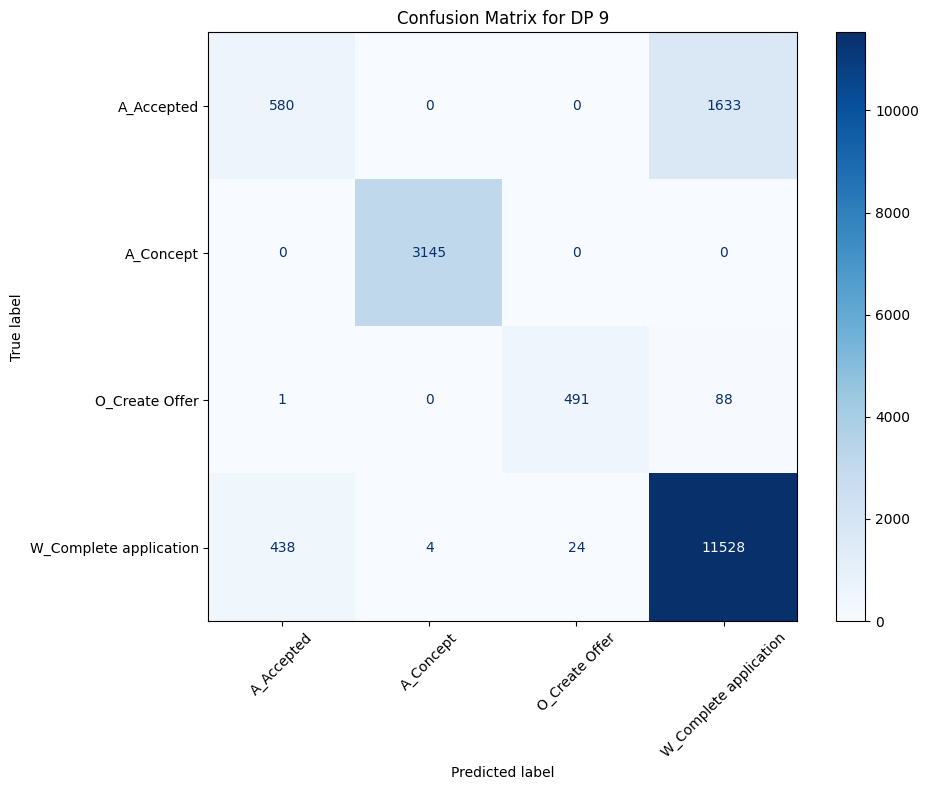

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 10 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.494
Relative Improvement:   73.84%


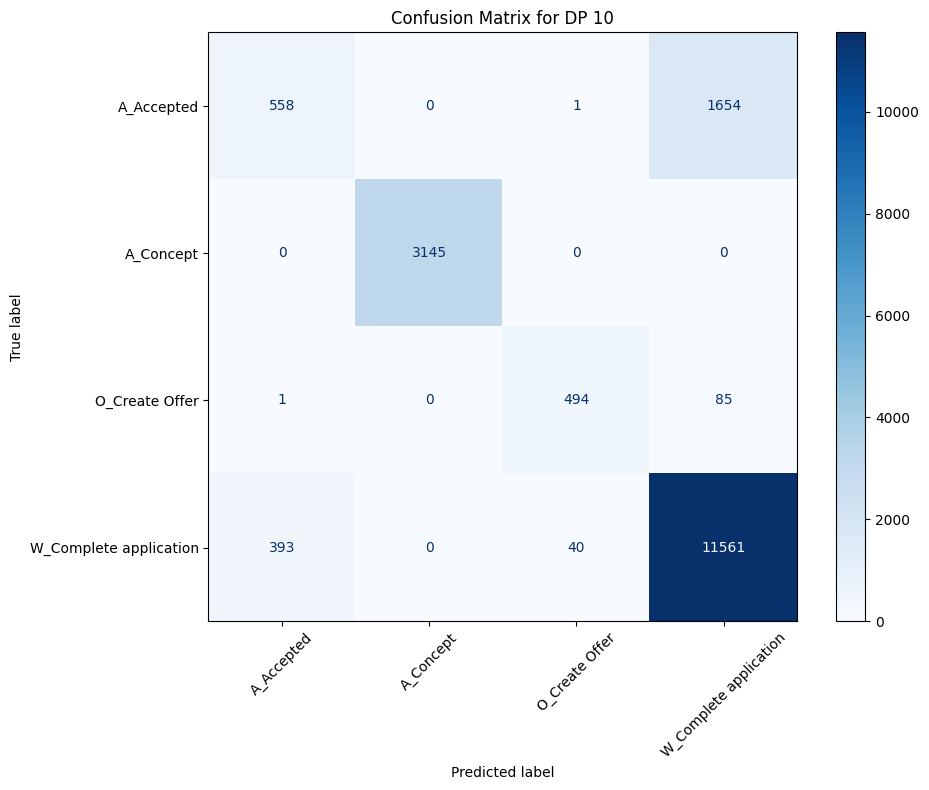

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 11 (Holdout Set)
Weighted F1 (LSTM):     0.850
Weighted F1 (Baseline): 0.658
Relative Improvement:   29.17%


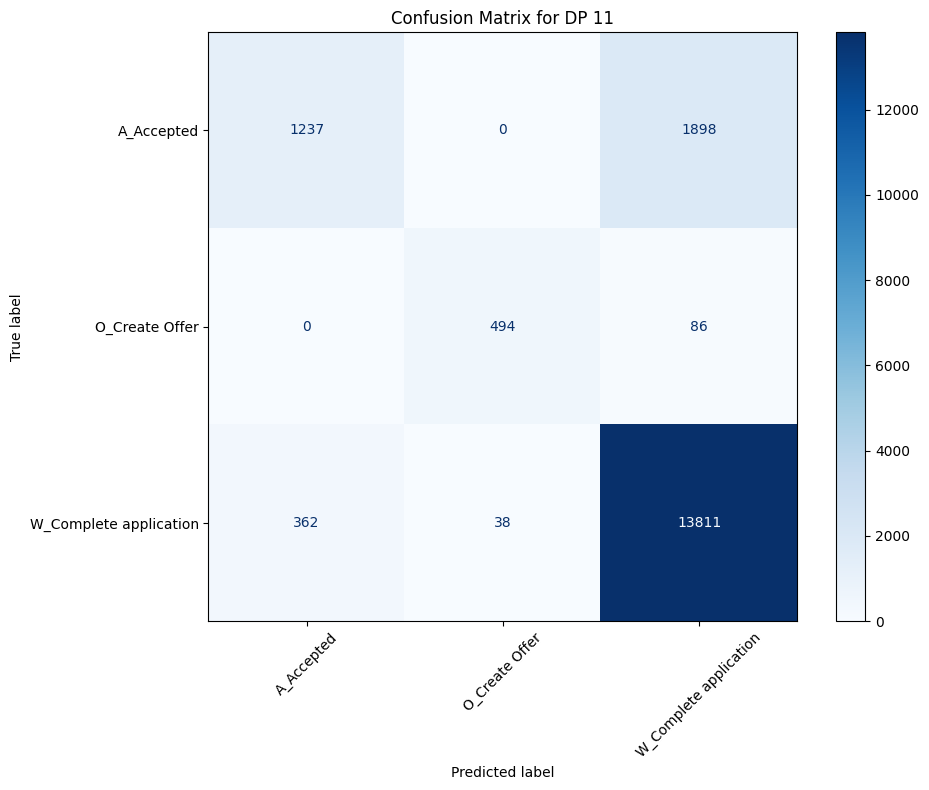

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 12 (Holdout Set)
Weighted F1 (LSTM):     0.847
Weighted F1 (Baseline): 0.658
Relative Improvement:   28.75%


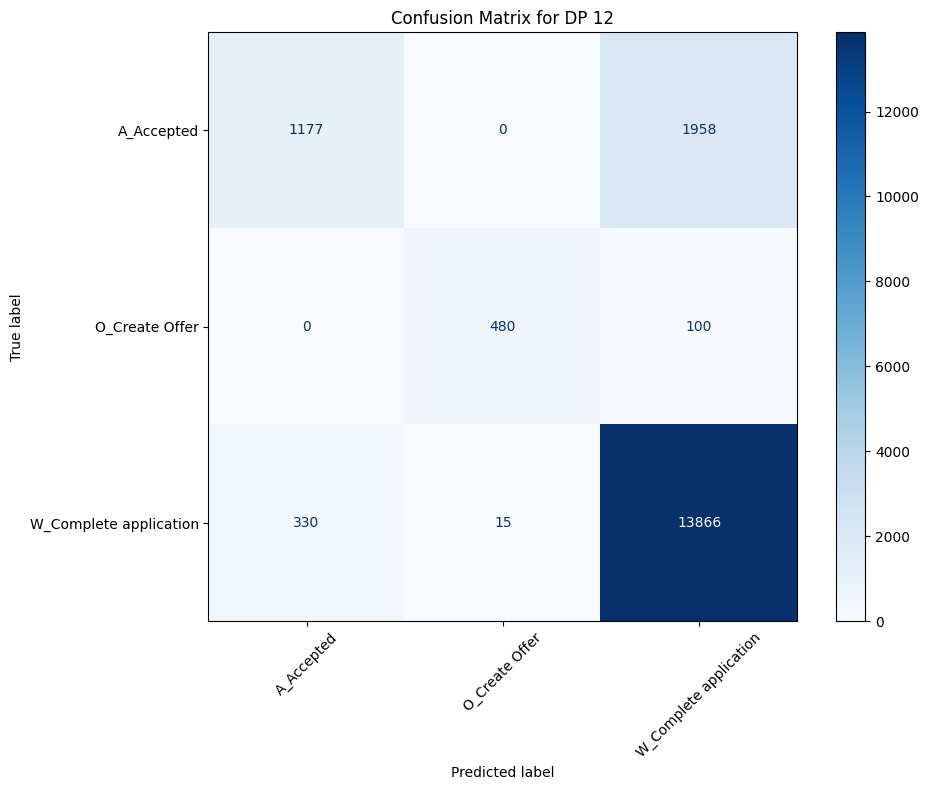

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 13 (Holdout Set)
Weighted F1 (LSTM):     0.987
Weighted F1 (Baseline): 0.688
Relative Improvement:   43.51%


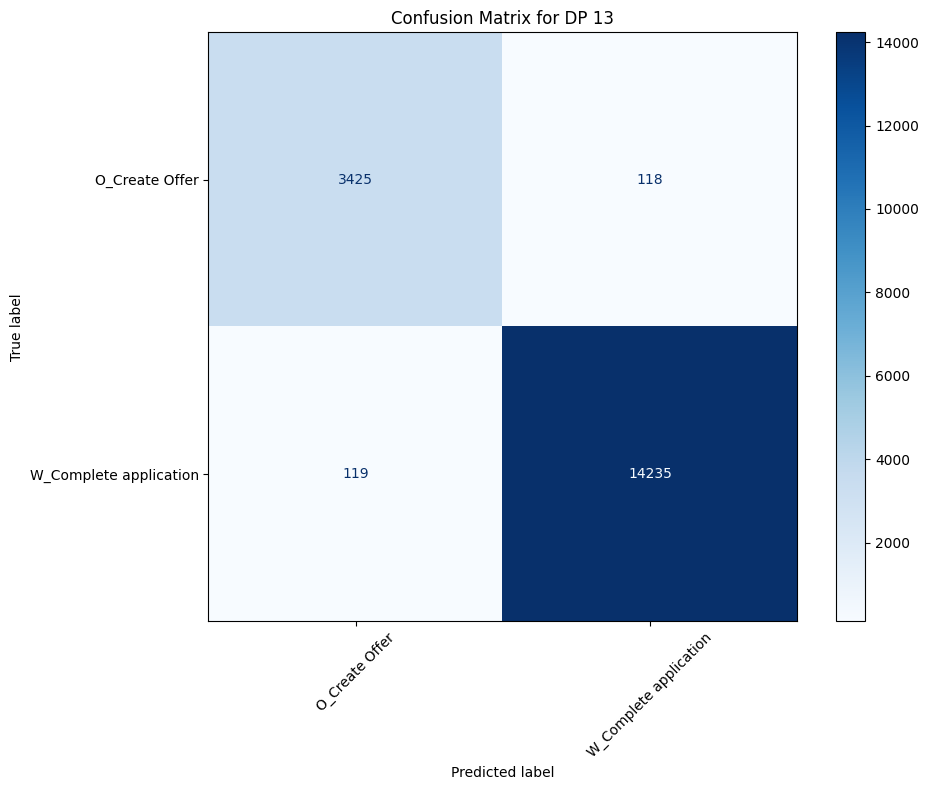

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 14 (Holdout Set)
Weighted F1 (LSTM):     0.968
Weighted F1 (Baseline): 0.930
Relative Improvement:   4.06%


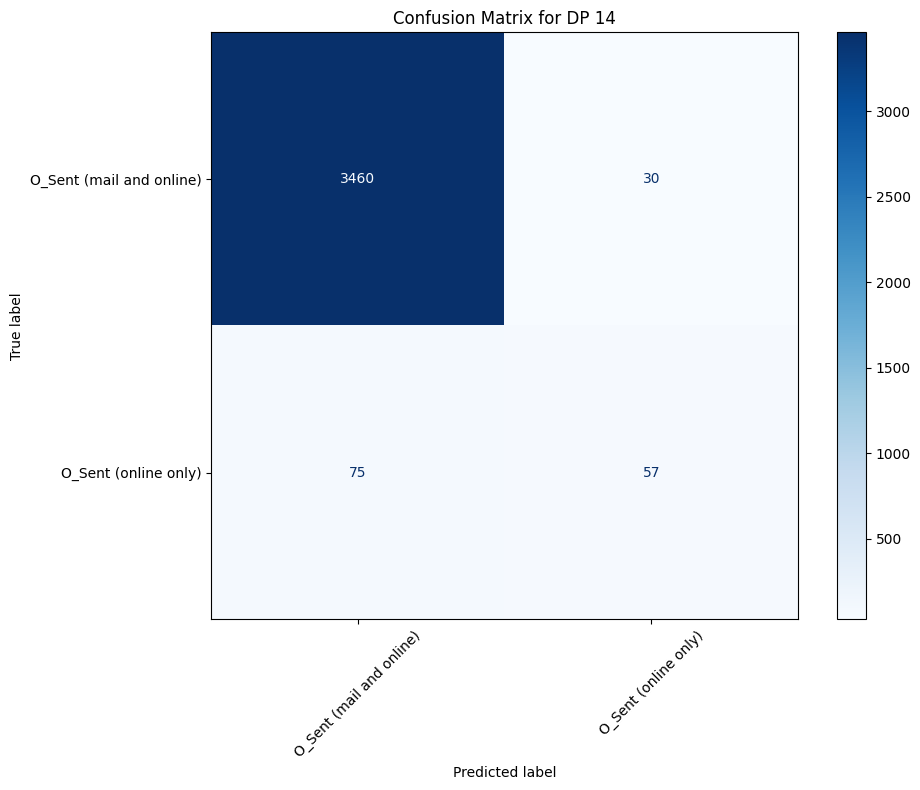

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 15 (Holdout Set)
Weighted F1 (LSTM):     0.971
Weighted F1 (Baseline): 0.930
Relative Improvement:   4.36%


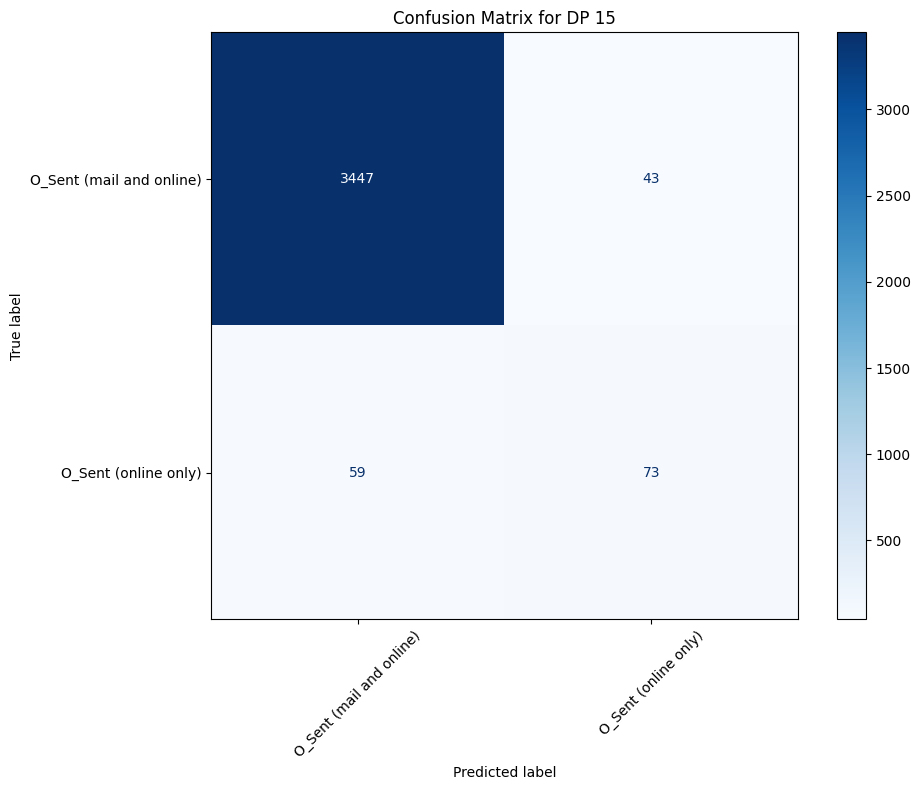

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 16 (Holdout Set)
Weighted F1 (LSTM):     0.983
Weighted F1 (Baseline): 0.796
Relative Improvement:   23.53%


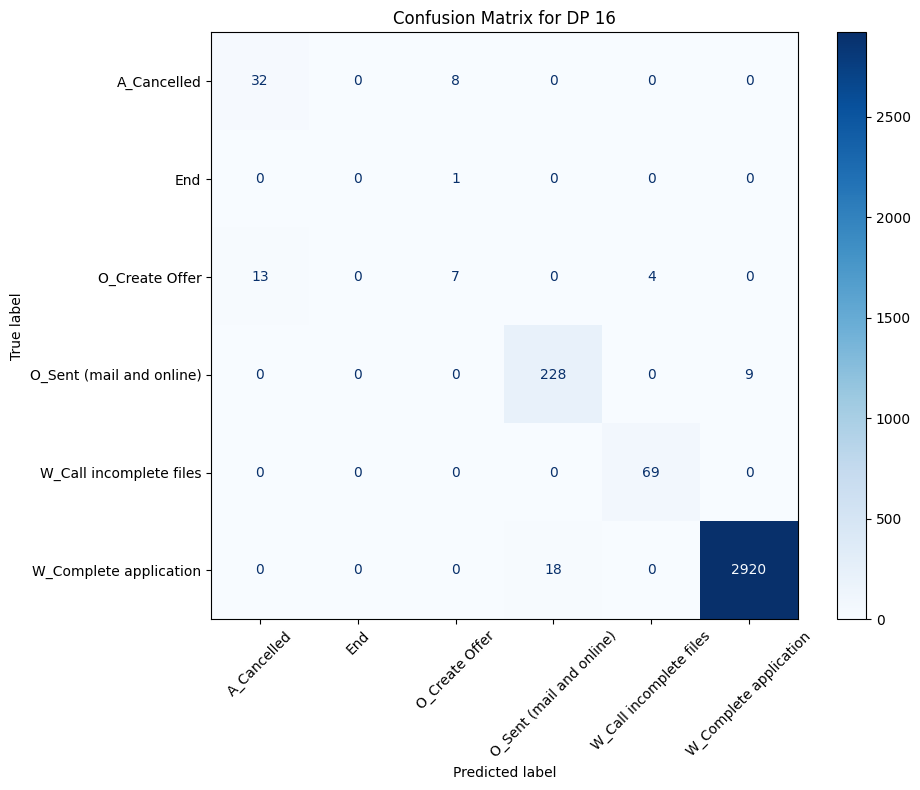

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 17 (Holdout Set)
Weighted F1 (LSTM):     0.985
Weighted F1 (Baseline): 0.796
Relative Improvement:   23.72%


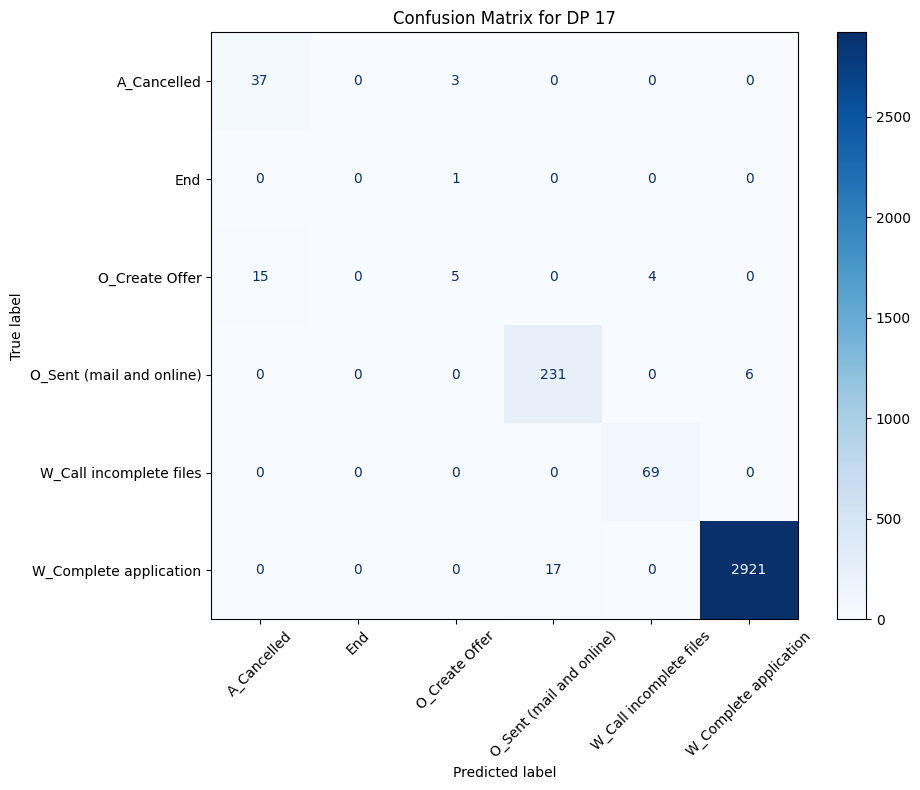

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 19 (Holdout Set)
Weighted F1 (LSTM):     0.884
Weighted F1 (Baseline): 0.414
Relative Improvement:   113.42%


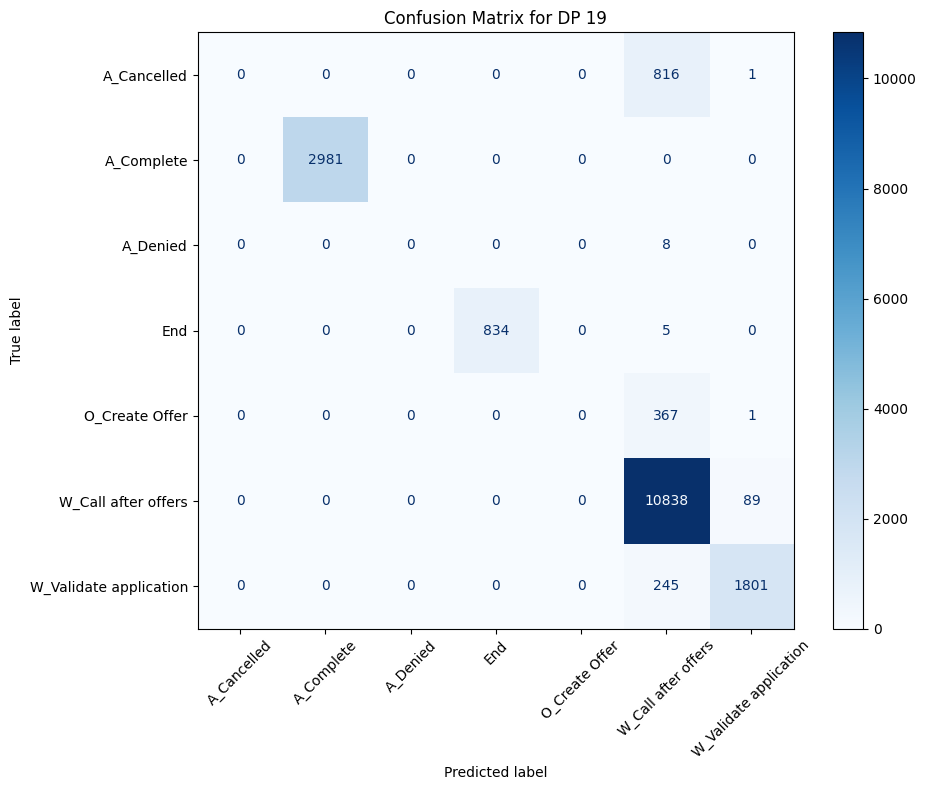

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 20 (Holdout Set)
Weighted F1 (LSTM):     0.881
Weighted F1 (Baseline): 0.414
Relative Improvement:   112.86%


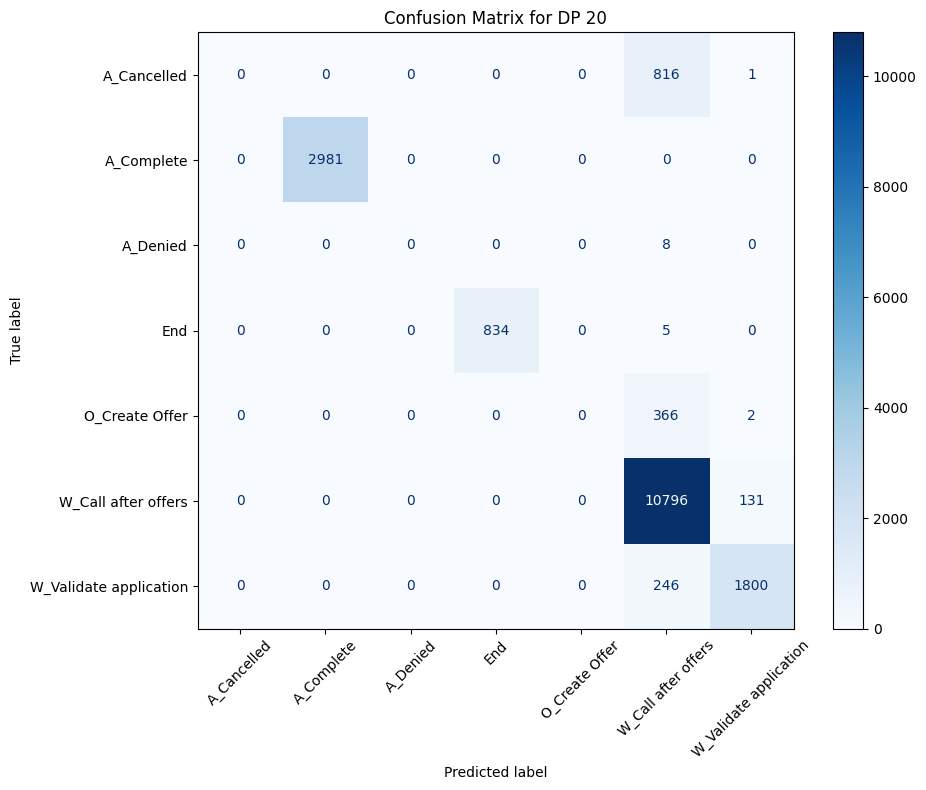

562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 21 (Holdout Set)
Weighted F1 (LSTM):     0.878
Weighted F1 (Baseline): 0.607
Relative Improvement:   44.65%


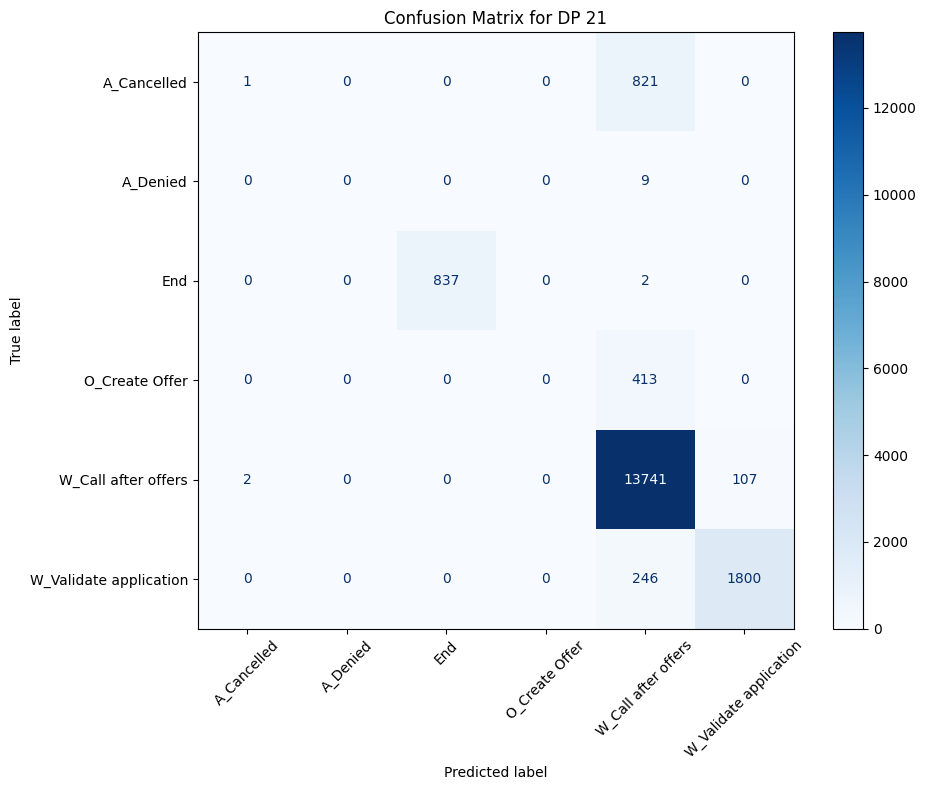

562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 22 (Holdout Set)
Weighted F1 (LSTM):     0.878
Weighted F1 (Baseline): 0.607
Relative Improvement:   44.63%


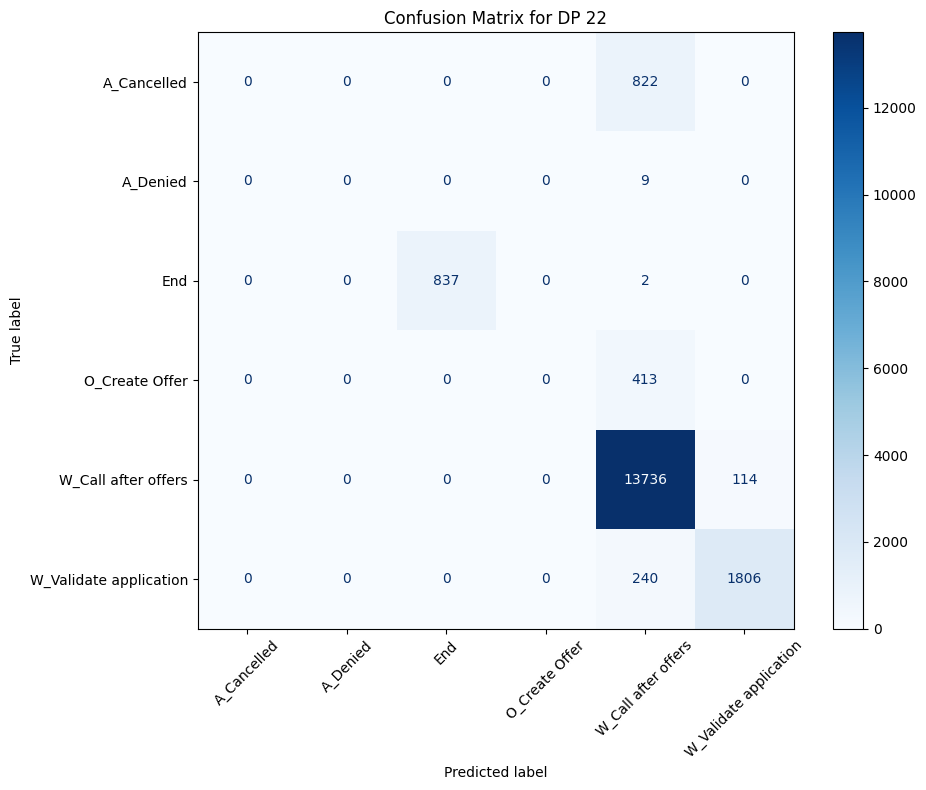

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 23 (Holdout Set)
Weighted F1 (LSTM):     0.952
Weighted F1 (Baseline): 0.278
Relative Improvement:   242.71%


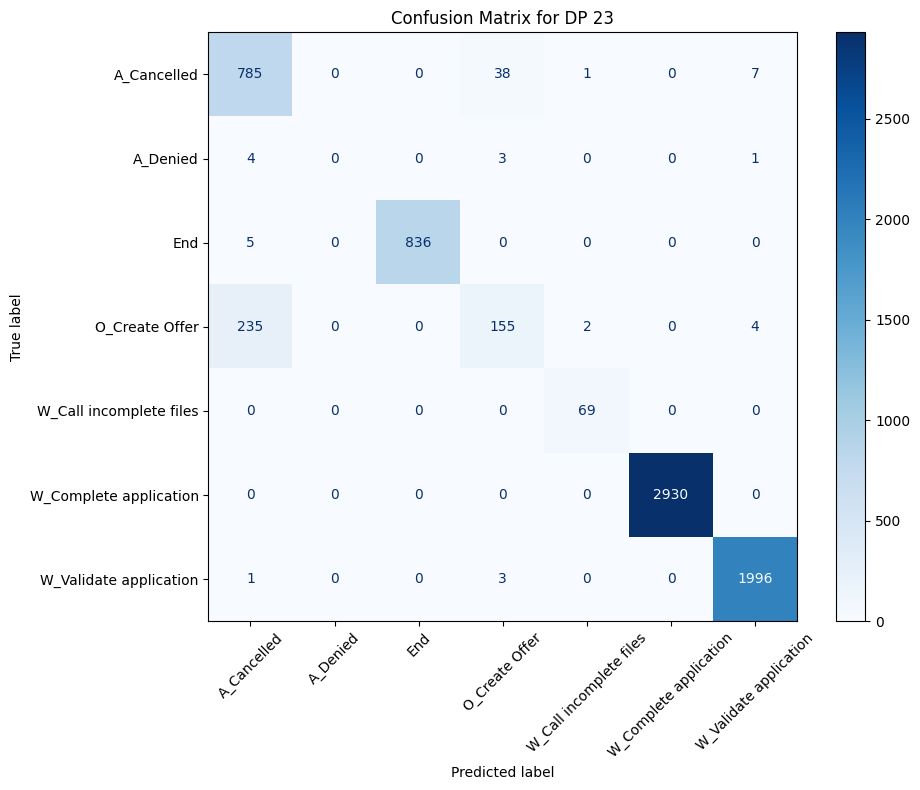

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 25 (Holdout Set)
Weighted F1 (LSTM):     0.818
Weighted F1 (Baseline): 0.438
Relative Improvement:   86.99%


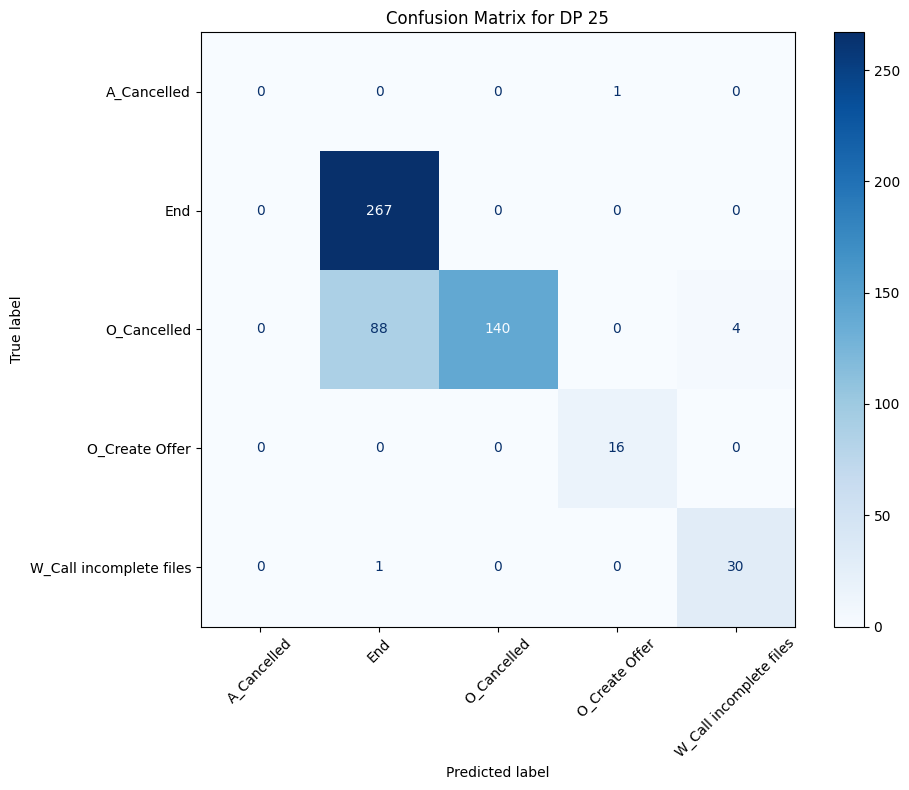

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 26 (Holdout Set)
Weighted F1 (LSTM):     0.957
Weighted F1 (Baseline): 0.270
Relative Improvement:   253.92%


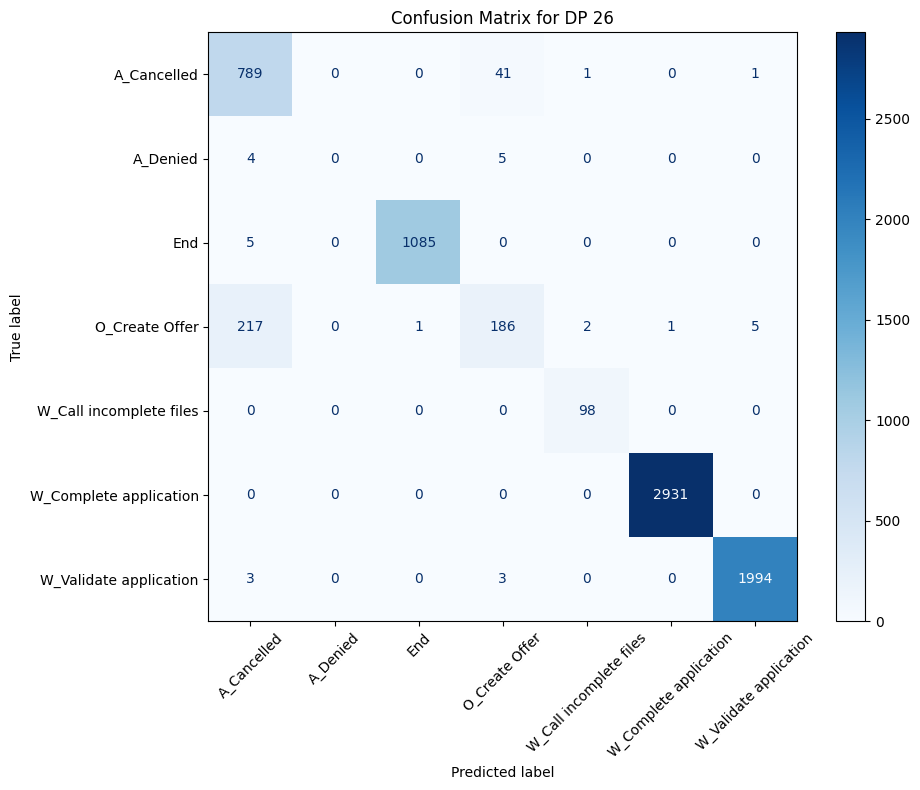

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 27 (Holdout Set)
Weighted F1 (LSTM):     0.856
Weighted F1 (Baseline): 0.329
Relative Improvement:   159.87%


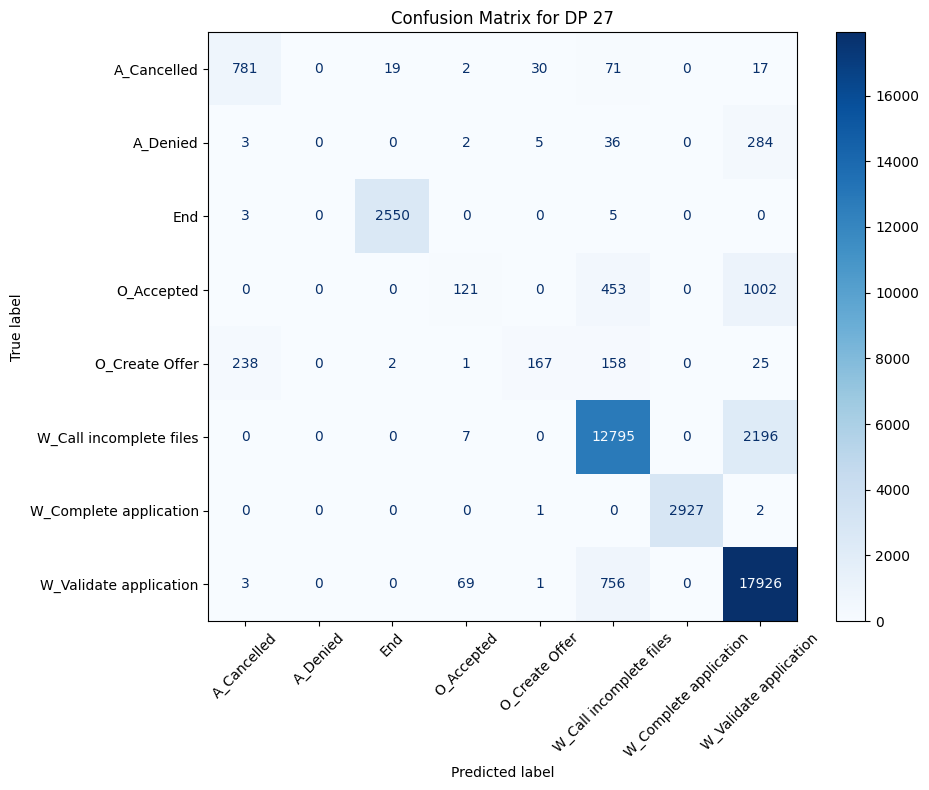

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 28 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.329
Relative Improvement:   160.89%


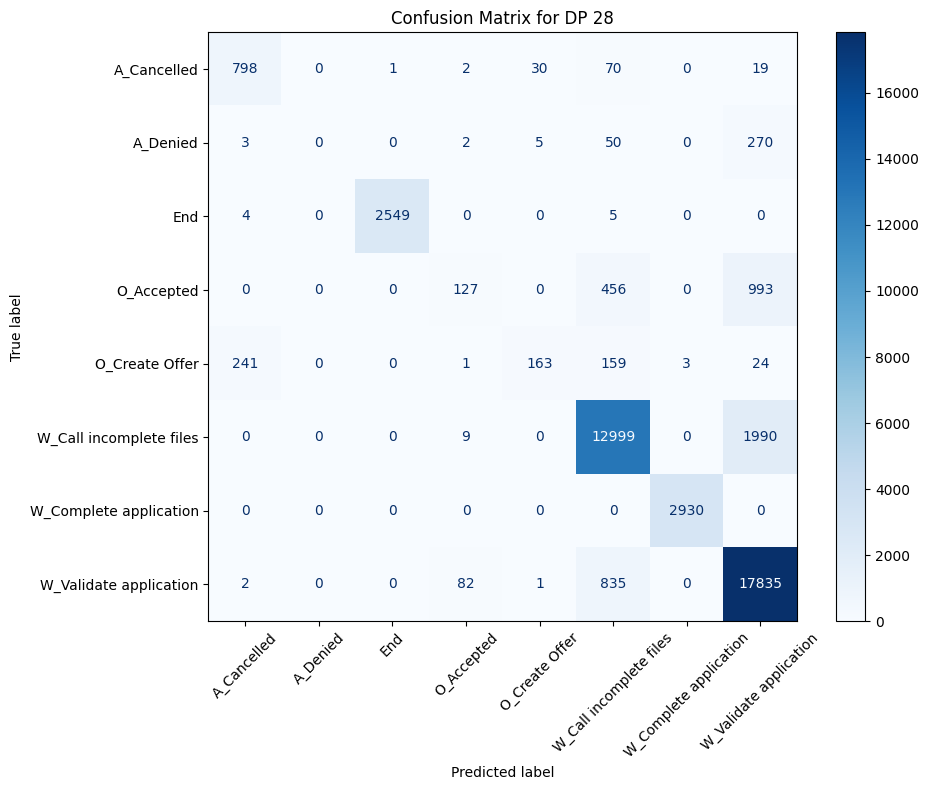

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 29 (Holdout Set)
Weighted F1 (LSTM):     0.858
Weighted F1 (Baseline): 0.329
Relative Improvement:   160.64%


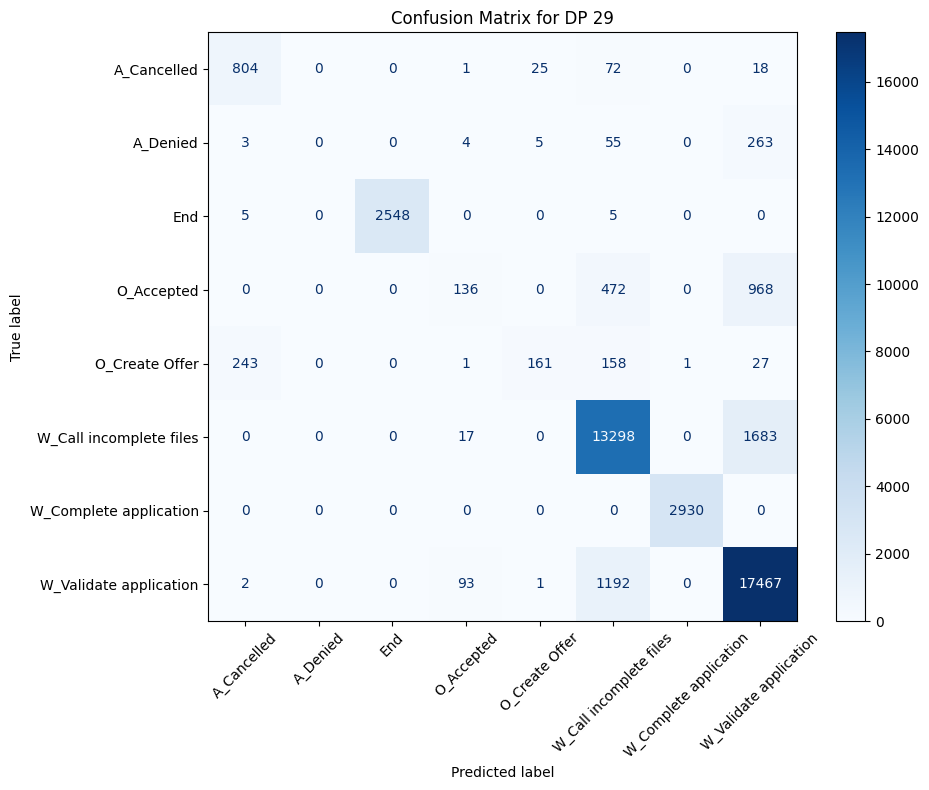

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 30 (Holdout Set)
Weighted F1 (LSTM):     0.862
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.82%


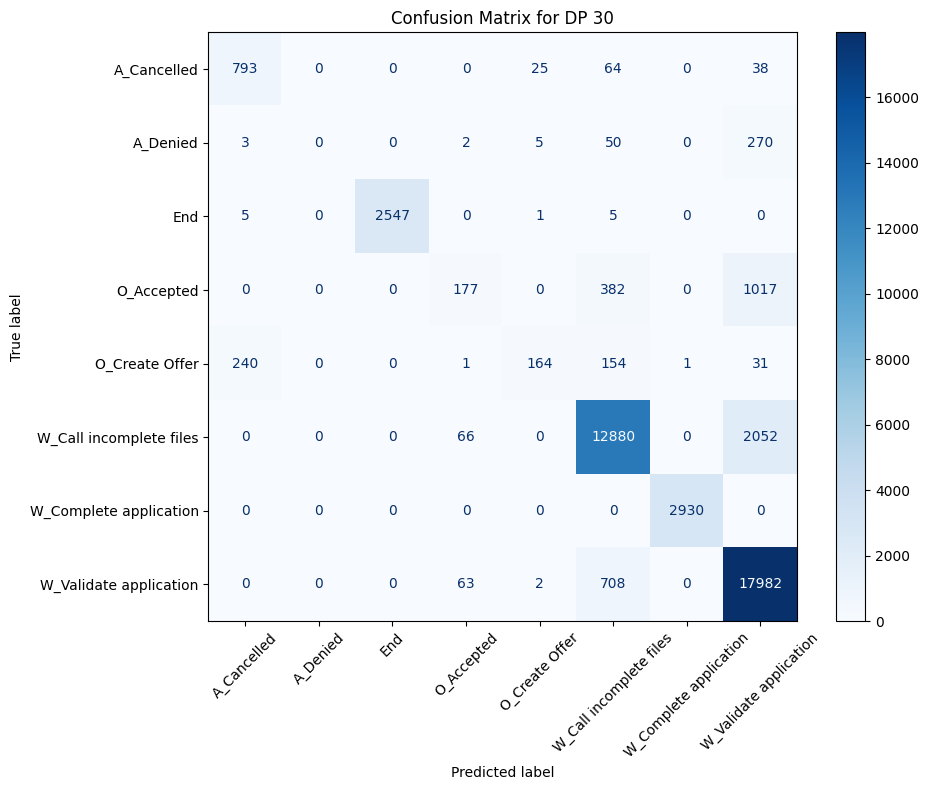

580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 31 (Holdout Set)
Weighted F1 (LSTM):     0.789
Weighted F1 (Baseline): 0.372
Relative Improvement:   112.50%


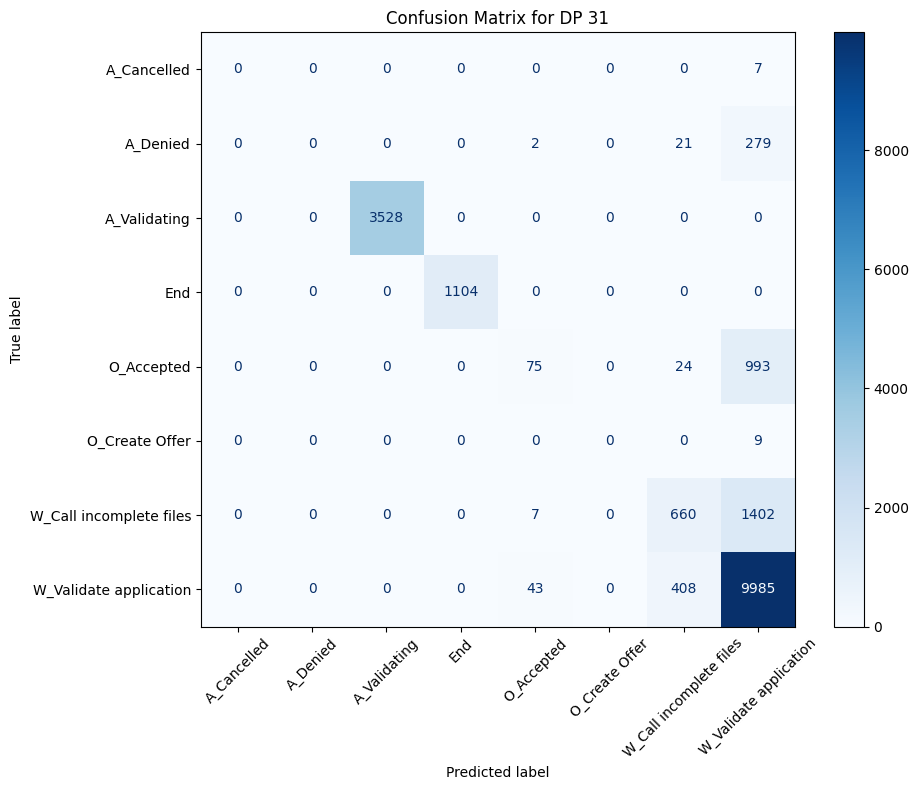

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 32 (Holdout Set)
Weighted F1 (LSTM):     0.864
Weighted F1 (Baseline): 0.329
Relative Improvement:   162.46%


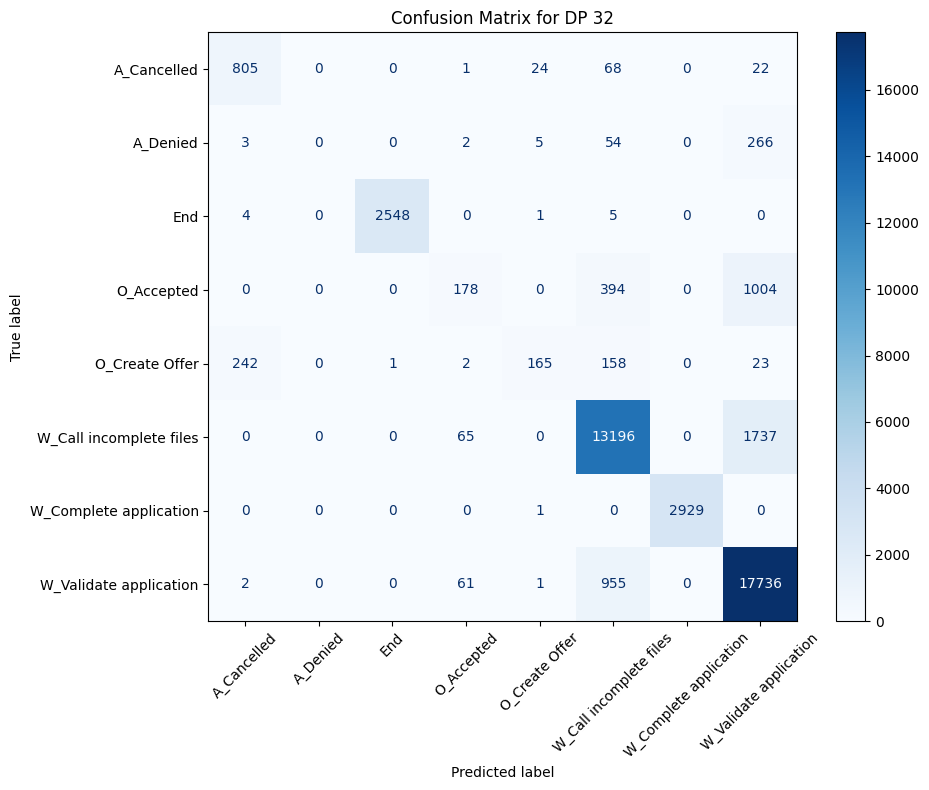

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 33 (Holdout Set)
Weighted F1 (LSTM):     0.948
Weighted F1 (Baseline): 0.508
Relative Improvement:   86.36%


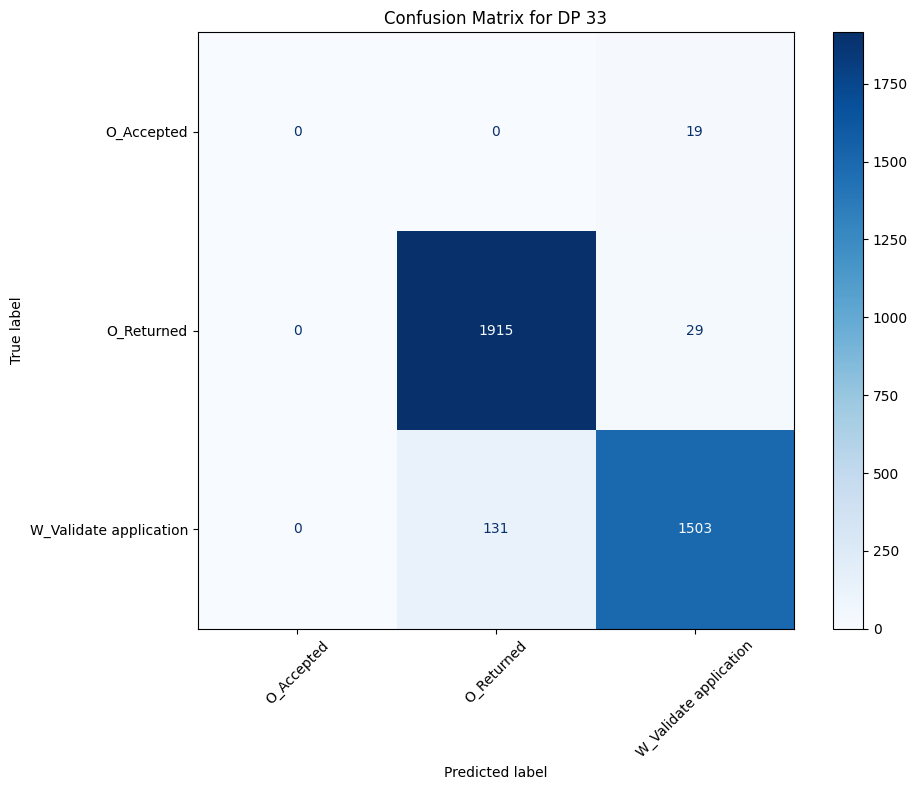

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 34 (Holdout Set)
Weighted F1 (LSTM):     0.854
Weighted F1 (Baseline): 0.329
Relative Improvement:   159.30%


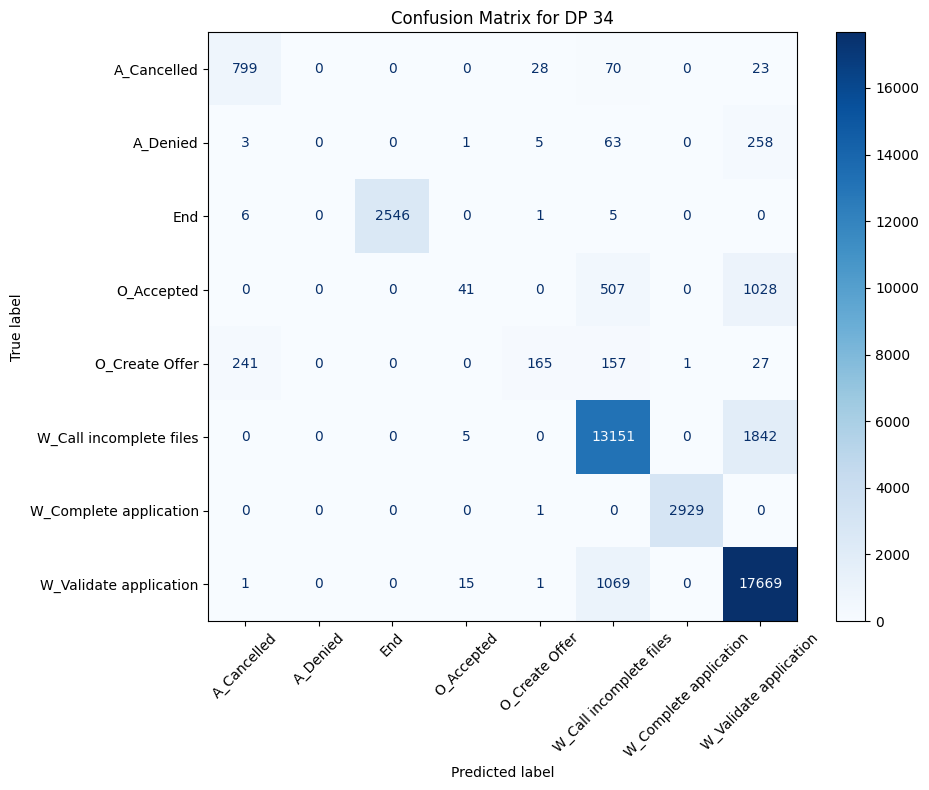

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 35 (Holdout Set)
Weighted F1 (LSTM):     0.861
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.31%


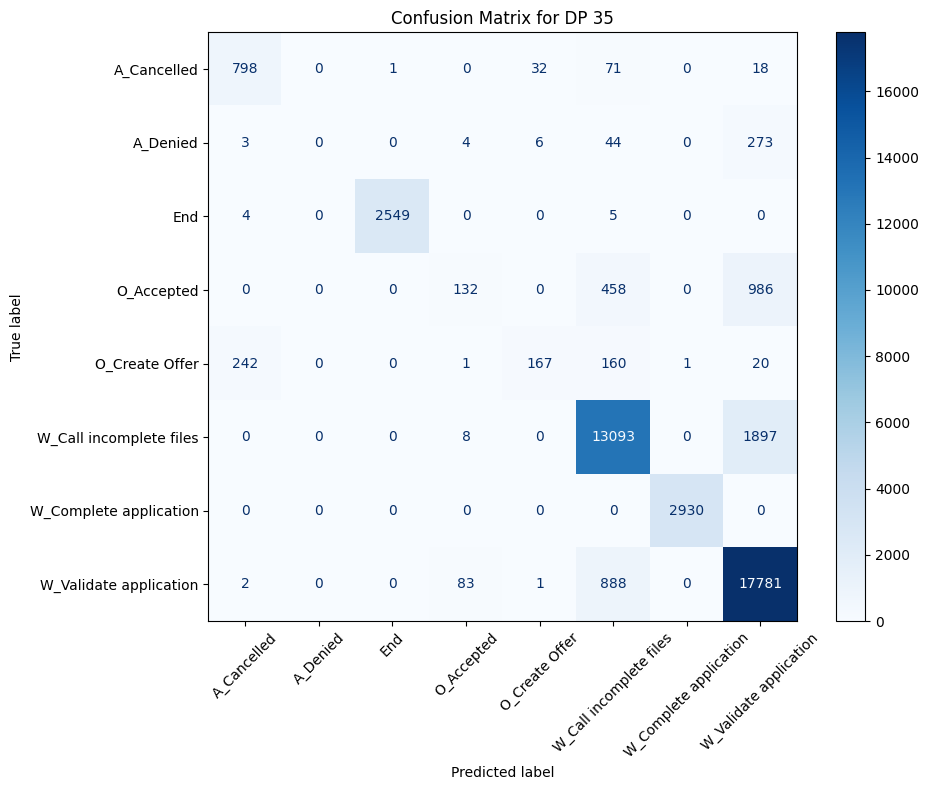

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 36 (Holdout Set)
Weighted F1 (LSTM):     0.862
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.85%


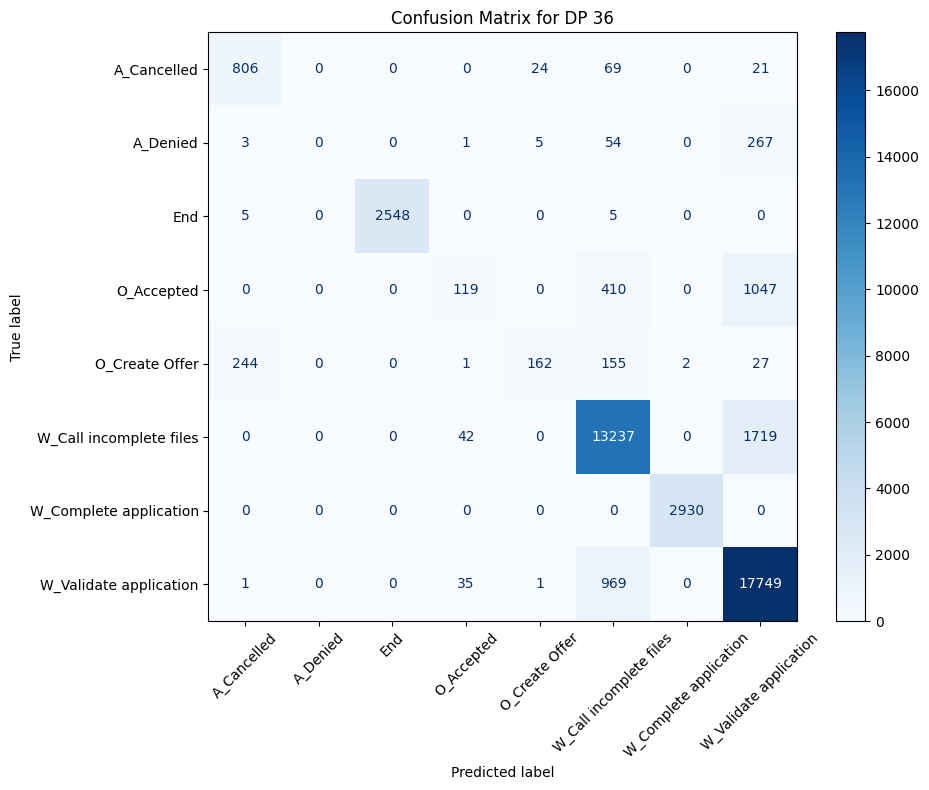

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 37 (Holdout Set)
Weighted F1 (LSTM):     0.856
Weighted F1 (Baseline): 0.329
Relative Improvement:   160.03%


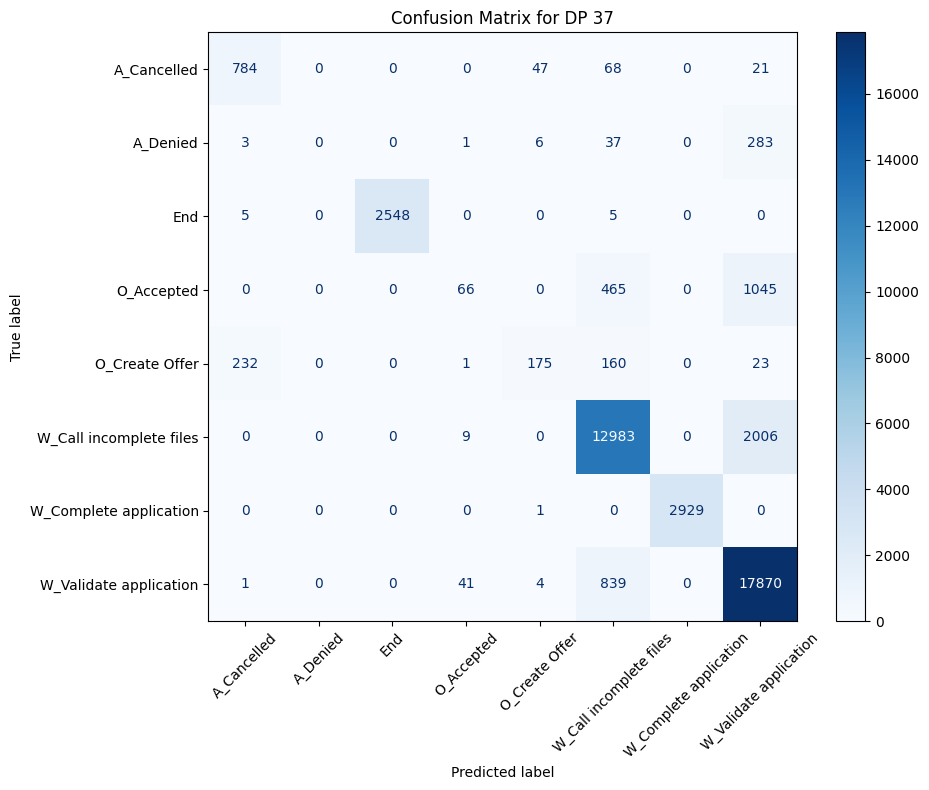

468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 39 (Holdout Set)
Weighted F1 (LSTM):     0.858
Weighted F1 (Baseline): 0.504
Relative Improvement:   70.23%


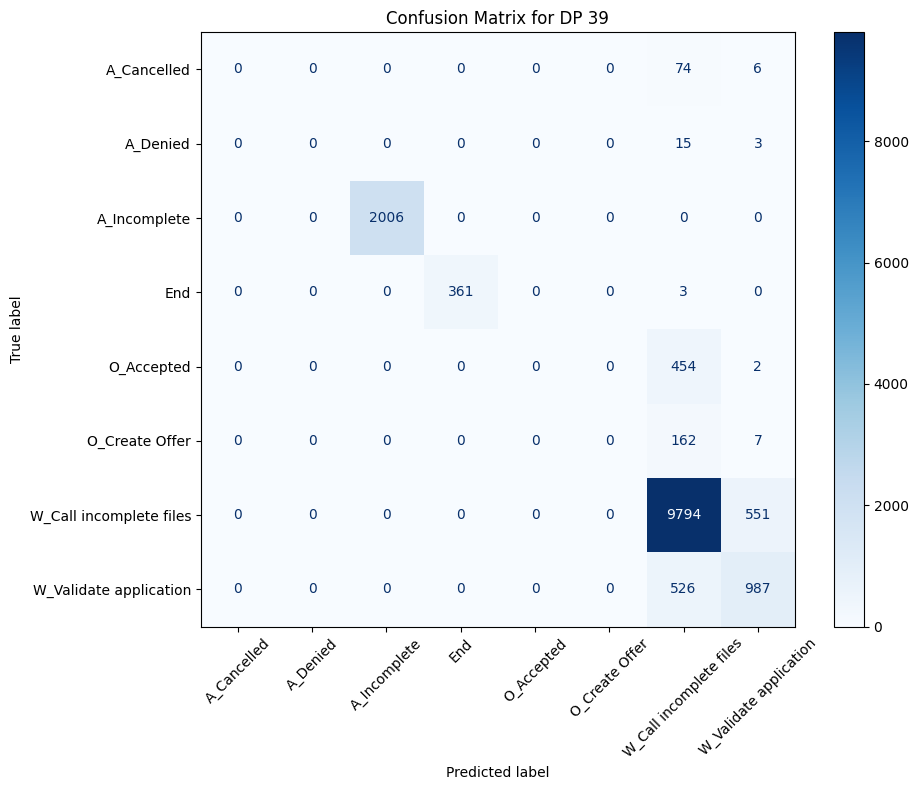

467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 40 (Holdout Set)
Weighted F1 (LSTM):     0.853
Weighted F1 (Baseline): 0.693
Relative Improvement:   23.17%


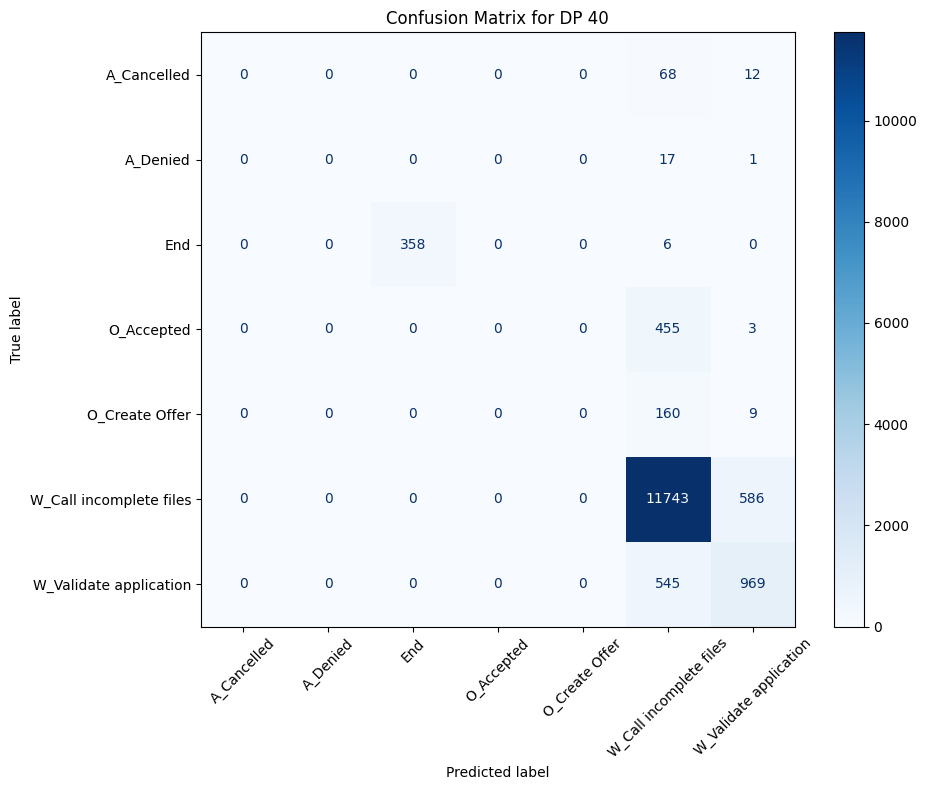

467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 41 (Holdout Set)
Weighted F1 (LSTM):     0.849
Weighted F1 (Baseline): 0.693
Relative Improvement:   22.54%


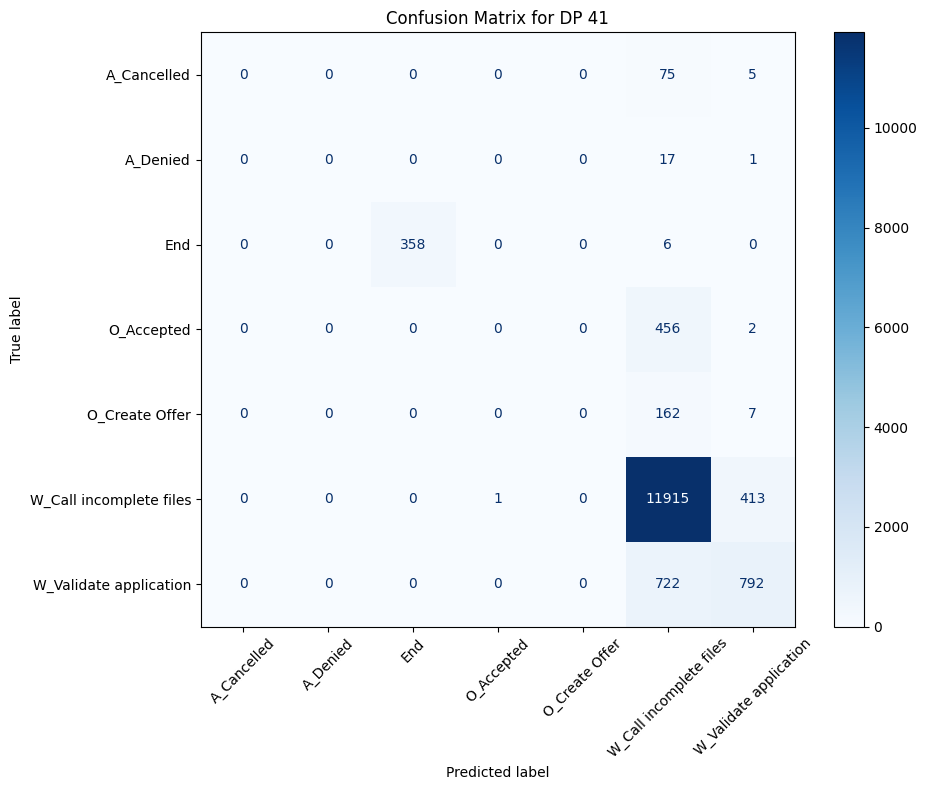

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 42 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.329
Relative Improvement:   160.71%


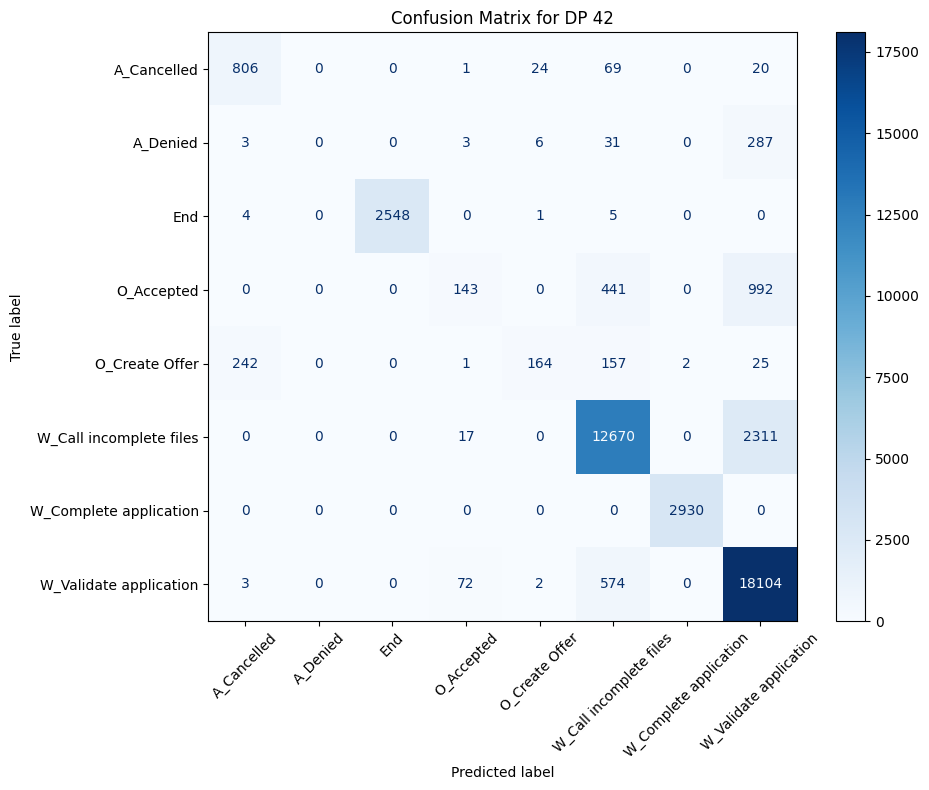

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 43 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.329
Relative Improvement:   160.93%


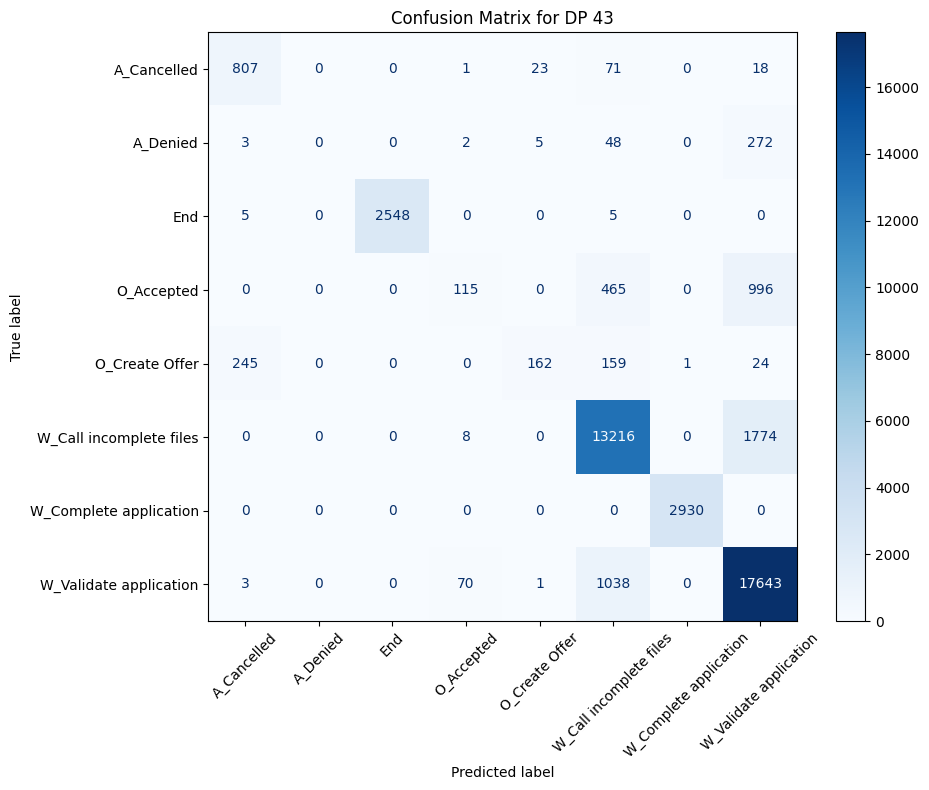

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 44 (Holdout Set)
Weighted F1 (LSTM):     0.879
Weighted F1 (Baseline): 0.431
Relative Improvement:   103.88%


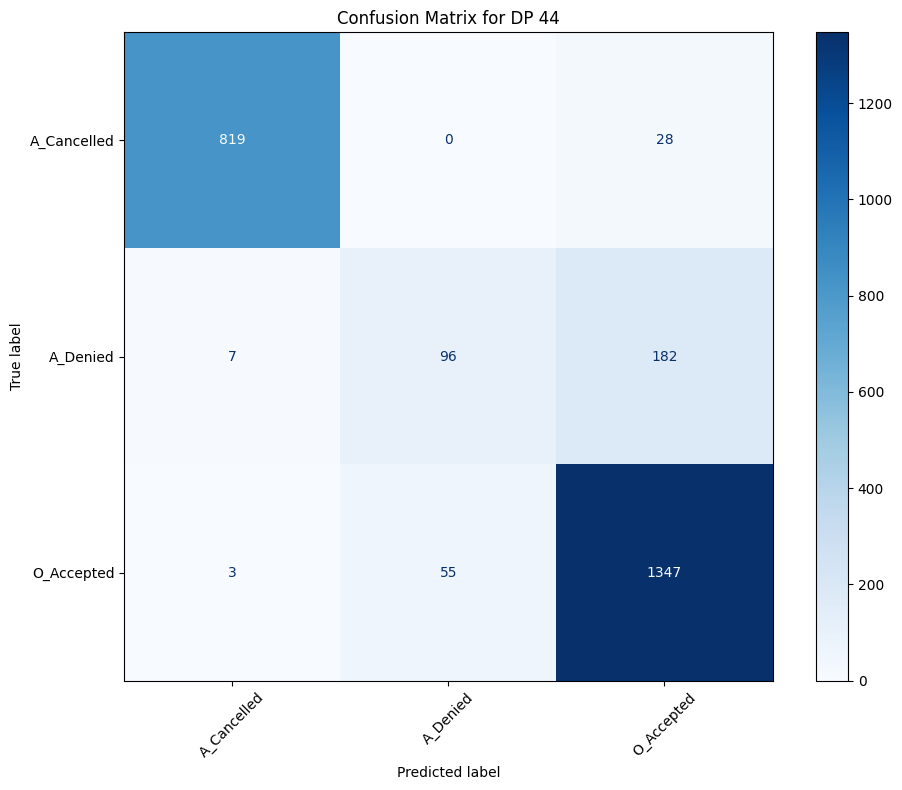

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 46 (Holdout Set)
Weighted F1 (LSTM):     0.818
Weighted F1 (Baseline): 0.438
Relative Improvement:   86.95%


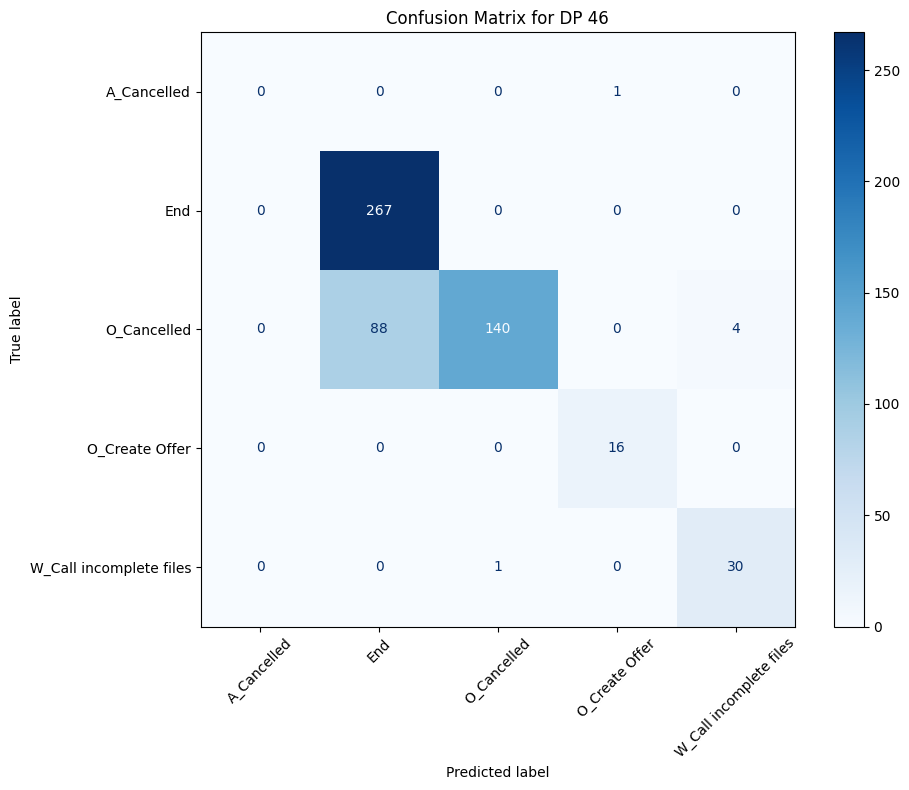

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 47 (Holdout Set)
Weighted F1 (LSTM):     0.999
Weighted F1 (Baseline): 0.476
Relative Improvement:   110.01%


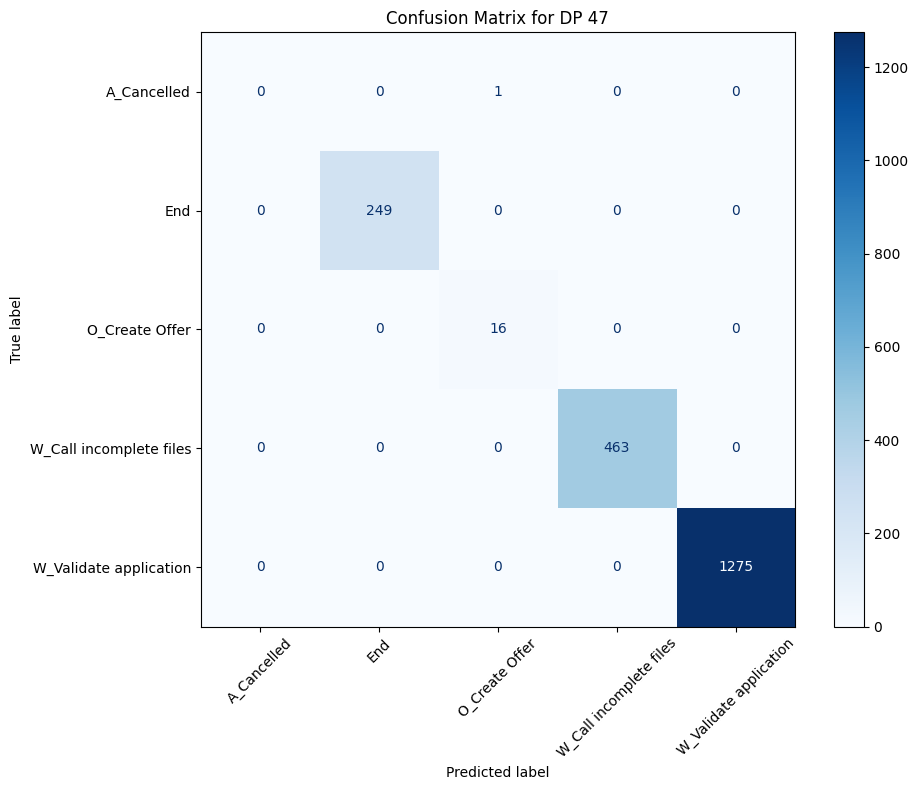

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 48 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.329
Relative Improvement:   160.76%


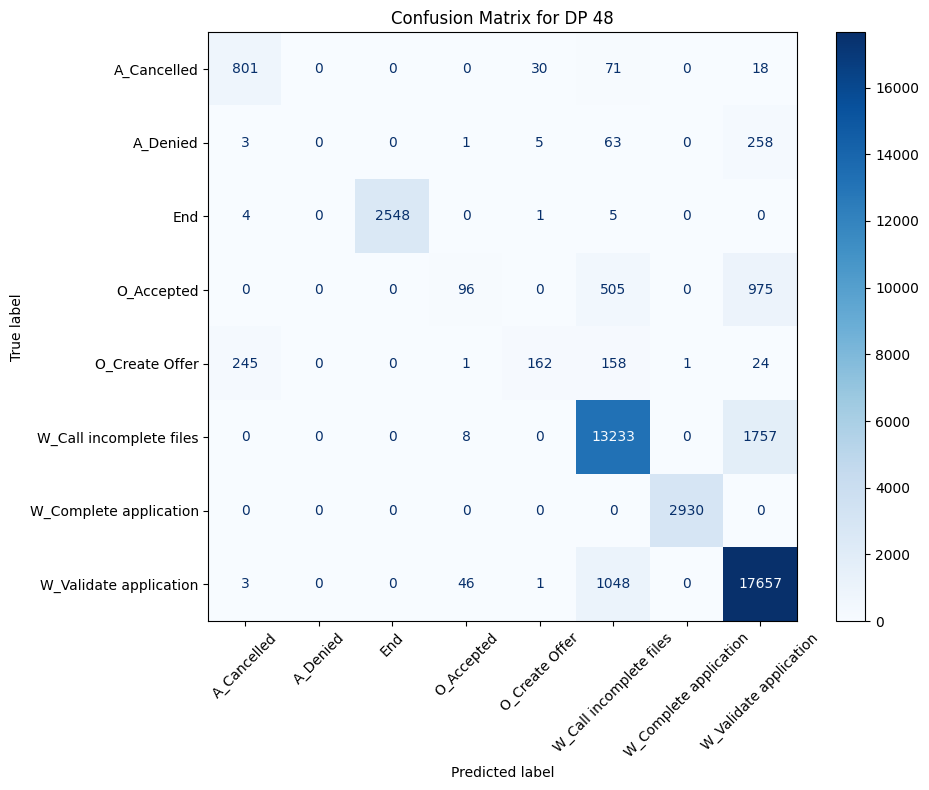

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 49 (Holdout Set)
Weighted F1 (LSTM):     0.851
Weighted F1 (Baseline): 0.329
Relative Improvement:   158.37%


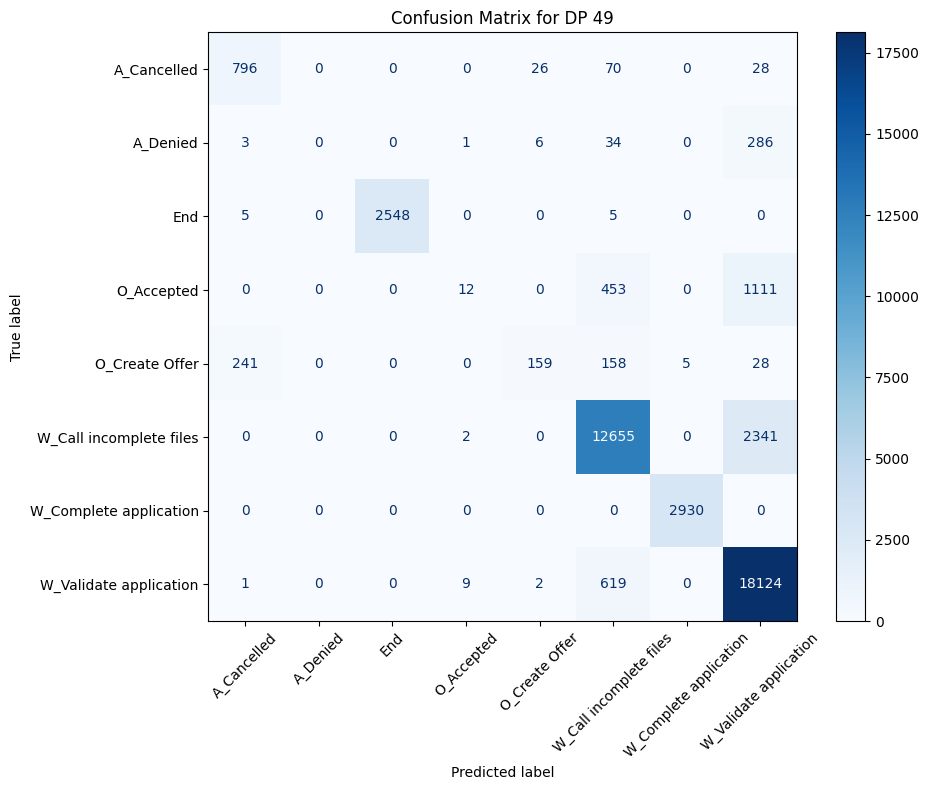

In [9]:
# Step: Build holdout data dict from dp_split_datasets
test_data_per_dp = {
    dp_name: splits["holdout"]
    for dp_name, splits in dp_split_datasets_full_simple.items()
    if "holdout" in splits and not splits["holdout"].empty
}

# Step: Run evaluation using your existing function
for dp in test_data_per_dp.keys():
    compare_f1_for_trained_model(dp, test_data_per_dp, decision_point_models_simple)

## 1.4 Permutation Importance

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7515 - loss: 0.5909 - val_accuracy: 0.9997 - val_loss: 0.0786
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0500 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9061 - loss: 0.2414 - val_accuracy: 0.9762 - val_loss: 0.0753
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9935 - loss: 0.0543 - val_accuracy: 0.9997 - val_loss: 0.0182
Epoch 3/10
222/222 ━━

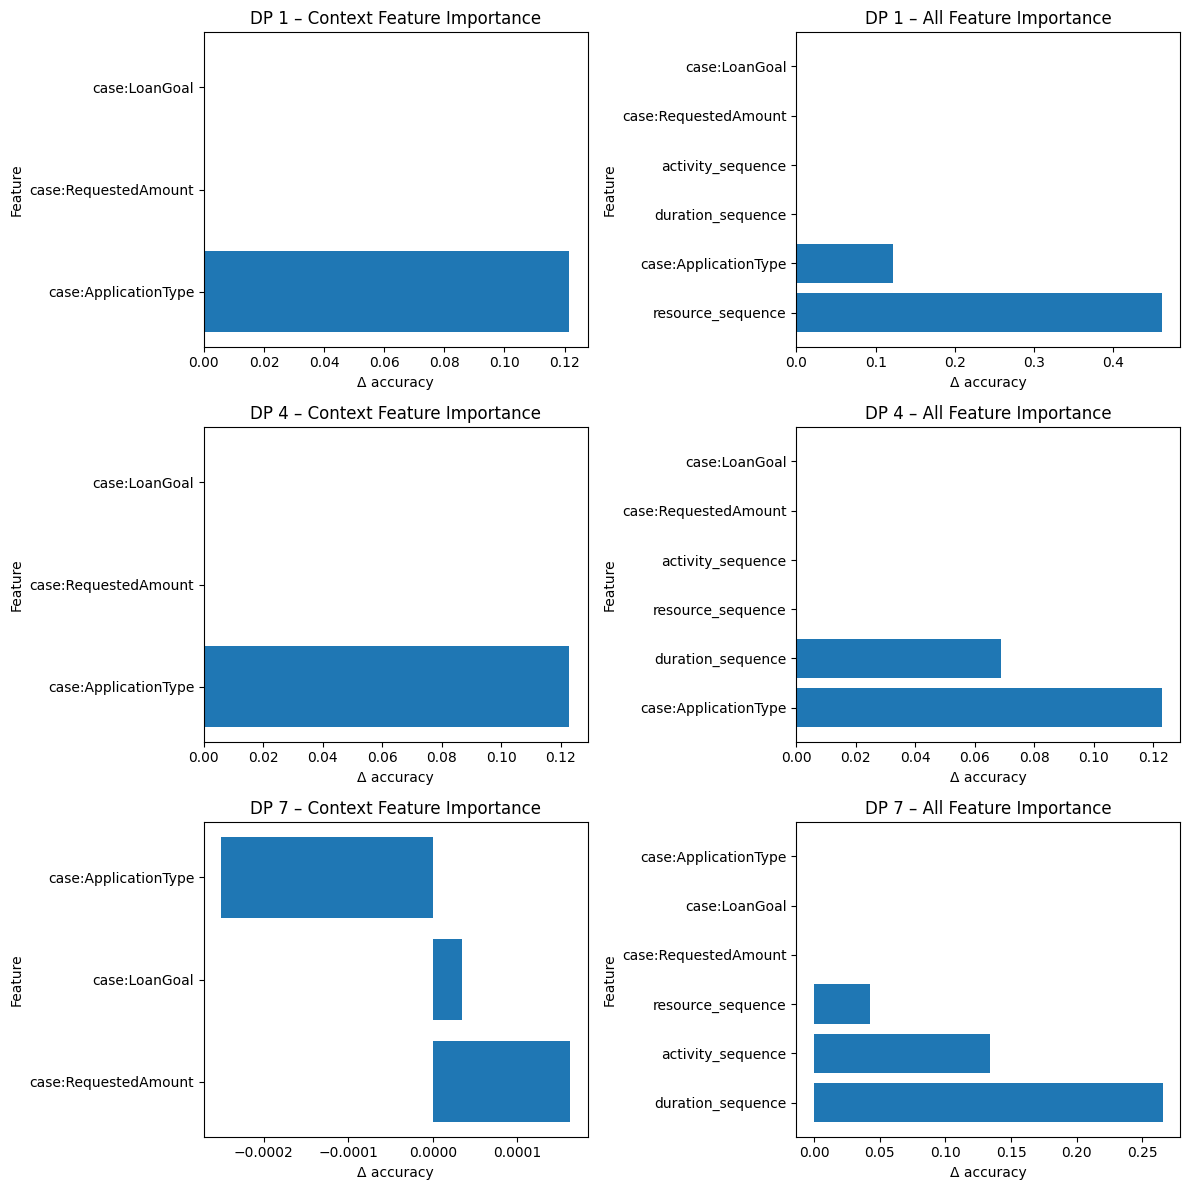

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# --- Helper ---
def add_unknown_label(encoder):
    if hasattr(encoder, "classes_") and "UNKNOWN" not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, "UNKNOWN")

# --- Config ---
DECISION_POINTS = [
    "DP 1",
    "DP 4",
    "DP 7",
]

CONTEXT_KEYS = ["case:LoanGoal", "case:ApplicationType", "case:RequestedAmount"]
N_REPEATS_CONTEXT = 10
N_REPEATS_ALL     = 10
RANDOM_SEED       = 42

# --- Run ---
results_per_dp = {}
summary_rows  = []

for decision_point in DECISION_POINTS:
    splits = dp_split_datasets_full_simple.get(decision_point)
    if not splits: 
        continue

    df_train = splits.get("train")
    df_test  = splits.get("test")
    df_hold  = splits.get("holdout")
    if any(x is None for x in (df_train, df_test, df_hold)):
        continue

    df_full = pd.concat([df_train, df_test, df_hold], ignore_index=True)
    if df_full.empty:
        continue

    # Prepare sequences
    X_acts_full, X_durs_full, X_res_full, act_enc, res_enc, lbl_enc, y_full, max_len = prepare_sequences_and_labels(df_full)
    X_ctx_full, ctx_dim, ctx_encoders = prepare_context_attributes(df_full, CONTEXT_KEYS)

    # Ensure "UNKNOWN" token where applicable
    for enc in (act_enc, res_enc, lbl_enc):
        add_unknown_label(enc)
    for enc in ctx_encoders.values():
        if isinstance(enc, LabelEncoder):
            add_unknown_label(enc)

    # Build & train
    model = build_lstm_model(
        num_activities=len(act_enc.classes_),
        num_resources=len(res_enc.classes_),
        context_dim=ctx_dim,
        max_seq_len=max_len,
        num_classes=len(lbl_enc.classes_),
    )
    train_model(model, [X_acts_full, X_durs_full, X_res_full, X_ctx_full], y_full)

    # Test tensors
    X_acts_test, X_durs_test, X_res_test, _, _, _, y_test, _ = prepare_sequences_and_labels(df_test)
    X_ctx_test, _, _ = prepare_context_attributes(df_test, CONTEXT_KEYS)

    # Permutation importance
    ctx_importances = permutation_importance_context(
        model, X_acts_test, X_durs_test, X_res_test, X_ctx_test, y_test,
        feature_names=CONTEXT_KEYS, n_repeats=N_REPEATS_CONTEXT, random_state=RANDOM_SEED
    )

    importances_all, feat_names_all, baseline_acc = permutation_importance_all_features(
        model, [X_acts_test, X_durs_test, X_res_test, X_ctx_test], y_test,
        CONTEXT_KEYS, n_repeats=N_REPEATS_ALL, random_state=RANDOM_SEED
    )

    results_per_dp[decision_point] = {
        "model": model,
        "activity_encoder": act_enc,
        "resource_encoder": res_enc,
        "label_encoder": lbl_enc,
        "context_keys": CONTEXT_KEYS,
        "context_encoders": ctx_encoders,
        "max_seq_len": max_len,
        "context_importance": pd.Series(ctx_importances, index=CONTEXT_KEYS),
        "all_importance": pd.Series(importances_all, index=feat_names_all),
        "baseline_accuracy": baseline_acc,
        "n_test_samples": int(len(X_acts_test)),
    }

    # collect summary row
    row = {
        "decision_point": decision_point,
        "baseline_accuracy": baseline_acc,
        "n_test_samples": int(len(X_acts_test))
    }
    for feat, imp in zip(CONTEXT_KEYS, ctx_importances):
        row[f"ctx::{feat}"] = float(imp)
    for feat, imp in zip(feat_names_all, importances_all):
        row[f"all::{feat}"] = float(imp)
    summary_rows.append(row)

# Summary table
df_dp_summary = pd.DataFrame(summary_rows).sort_values(by="decision_point").reset_index(drop=True)

# --- Grid plots: up to 3 DPs, each with two subplots (context | all features) ---
dps_to_plot = [dp for dp in DECISION_POINTS if dp in results_per_dp][:3]
if dps_to_plot:
    fig, axes = plt.subplots(len(dps_to_plot), 2, figsize=(12, 4 * len(dps_to_plot)), squeeze=False)

    for i, dp in enumerate(dps_to_plot):
        ctx = results_per_dp[dp]["context_importance"].sort_values(ascending=True)
        all_imp = results_per_dp[dp]["all_importance"].sort_values(ascending=True)

        # Left: context importance
        ax = axes[i, 0]
        ax.barh(ctx.index, ctx.values)
        ax.invert_yaxis()
        ax.set_title(f"{dp} – Context Feature Importance")
        ax.set_xlabel("Δ accuracy")
        ax.set_ylabel("Feature")

        # Right: all features importance
        ax = axes[i, 1]
        ax.barh(all_imp.index, all_imp.values)
        ax.invert_yaxis()
        ax.set_title(f"{dp} – All Feature Importance")
        ax.set_xlabel("Δ accuracy")
        ax.set_ylabel("Feature")

    fig.tight_layout()
    plt.show()

In [11]:
results_dir = (Path.cwd().parent / "results") if Path.cwd().name == "notebooks" else Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

# use existing fig handle if available; otherwise grab current figure
try:
    _fig = fig
except NameError:
    _fig = plt.gcf()

save_path = results_dir / "feature_importance_grid_simple.png"
_fig.savefig(save_path, dpi=200, bbox_inches="tight")
print(f"Plot saved to: {save_path.resolve()}")

Plot saved to: /Users/m.ohmayer/Desktop/next_activity_prediction/results/feature_importance_grid_simple.png


## 1.5 Evaluation Plots and Metrics

In [ ]:
# --- Per-Decision Point Aggregates ---
dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)

dp_metrics_baseline = df_baseline.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)


OUT_DIR = Path("../data/evaluation")
OUT_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(dp_metrics_lstm,     OUT_DIR / "dp_metrics_lstm_simple.joblib")
joblib.dump(dp_metrics_baseline, OUT_DIR / "dp_metrics_baseline.joblib")

NameError: name 'df_accuracy' is not defined

In [ ]:
# --- Mean and Std per model ---
mean_precision_lstm = dp_metrics_lstm["precision"].mean()
std_precision_lstm = dp_metrics_lstm["precision"].std()

mean_recall_lstm = dp_metrics_lstm["recall"].mean()
std_recall_lstm = dp_metrics_lstm["recall"].std()

mean_f1_lstm = dp_metrics_lstm["f1_score"].mean()
std_f1_lstm = dp_metrics_lstm["f1_score"].std()

mean_precision_baseline = dp_metrics_baseline["precision"].mean()
std_precision_baseline = dp_metrics_baseline["precision"].std()

mean_recall_baseline = dp_metrics_baseline["recall"].mean()
std_recall_baseline = dp_metrics_baseline["recall"].std()

mean_f1_baseline = dp_metrics_baseline["f1_score"].mean()
std_f1_baseline = dp_metrics_baseline["f1_score"].std()

# --- Print Global + Std ---
print("\n=== Aggregated Across Decision Points ===")
print(f"Precision (LSTM):     {mean_precision_lstm:.3f} ± {std_precision_lstm:.3f}")
print(f"Precision (Baseline): {mean_precision_baseline:.3f} ± {std_precision_baseline:.3f}\n")

print(f"Recall (LSTM):        {mean_recall_lstm:.3f} ± {std_recall_lstm:.3f}")
print(f"Recall (Baseline):    {mean_recall_baseline:.3f} ± {std_recall_baseline:.3f}\n")

print(f"F1-score (LSTM):      {mean_f1_lstm:.3f} ± {std_f1_lstm:.3f}")
print(f"F1-score (Baseline):  {mean_f1_baseline:.3f} ± {std_f1_baseline:.3f}")


=== Aggregated Across Decision Points ===
Precision (LSTM):     89.098 ± 5.996
Precision (Baseline): 49.678 ± 18.679

Recall (LSTM):        90.485 ± 5.364
Recall (Baseline):    49.533 ± 18.577

F1-score (LSTM):      89.022 ± 6.141
F1-score (Baseline):  49.603 ± 18.628


/var/folders/ct/jknbc8jj3yb54ssrdbml90z00000gn/T/ipykernel_59047/1819151002.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
/var/folders/ct/jknbc8jj3yb54ssrdbml90z00000gn/T/ipykernel_59047/1819151002.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_baseline = df_baseline.groupby("decision_point").apply(


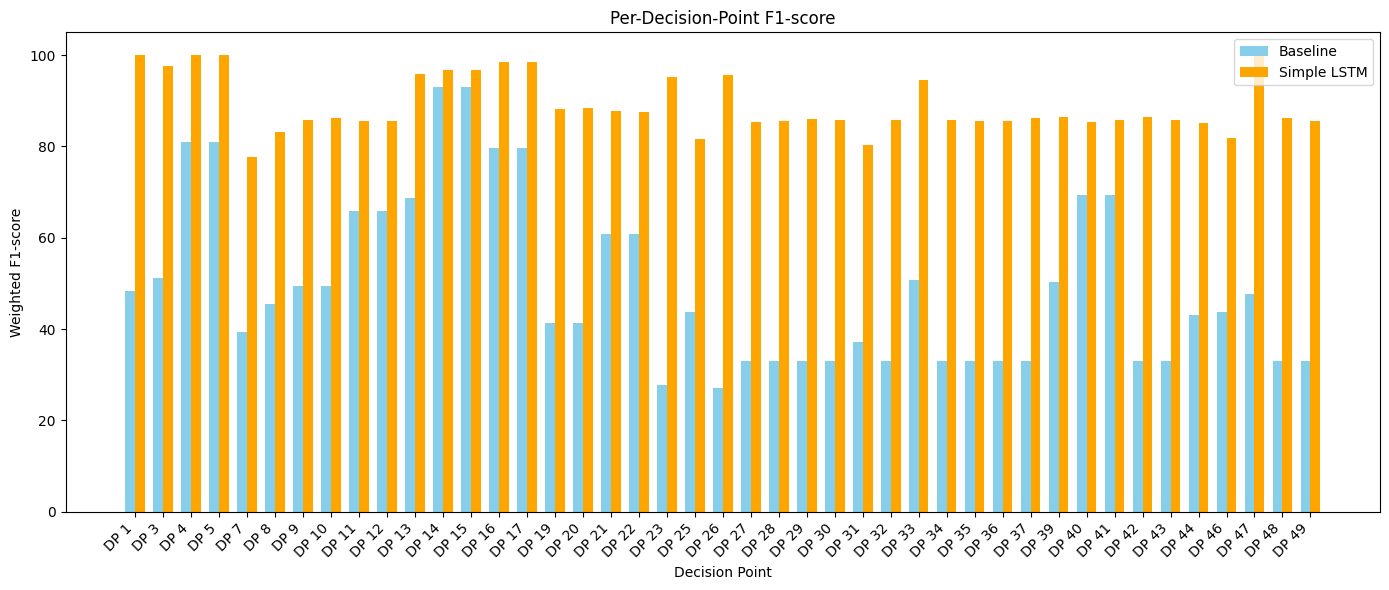

In [9]:
# Combine metrics
dp_metrics = pd.DataFrame({
    "baseline_f1": dp_metrics_baseline["f1_score"],
    "lstm_f1": dp_metrics_lstm["f1_score"]
})

# Extract numeric part for sorting
def extract_dp_number(dp_name):
    match = re.search(r'\d+', dp_name)
    return int(match.group()) if match else float('inf')

dp_metrics["dp_number"] = dp_metrics.index.map(extract_dp_number)
dp_metrics = dp_metrics.sort_values("dp_number")

# Plot
x = np.arange(len(dp_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, dp_metrics["baseline_f1"], width, label="Baseline", color="skyblue")
bars2 = ax.bar(x + width/2, dp_metrics["lstm_f1"], width, label="Simple LSTM", color="orange")

ax.set_xlabel("Decision Point")
ax.set_ylabel("Weighted F1-score")
ax.set_title("Per-Decision-Point F1-score")
ax.set_xticks(x)
ax.set_xticklabels(dp_metrics.index, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

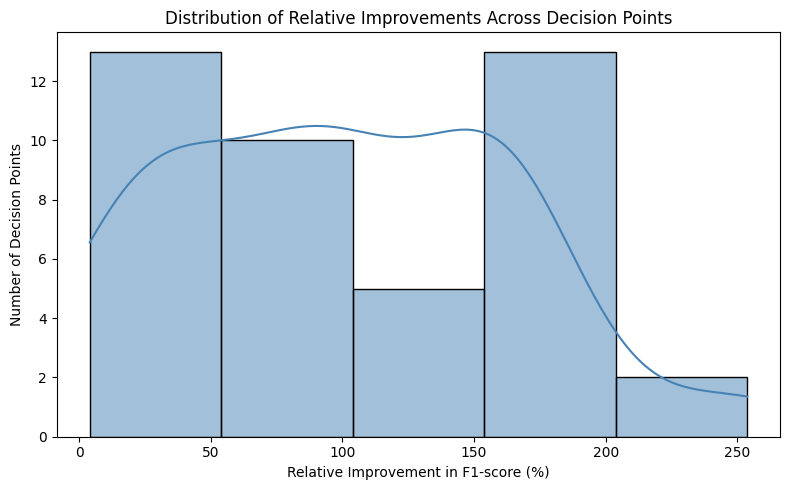

In [10]:
# Calculate %ΔF1 for each decision point
relative_improvement_f1_dp = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"])
    / dp_metrics_baseline["f1_score"] * 100
)

# Plot histogram + KDE
plt.figure(figsize=(8, 5))
sns.histplot(relative_improvement_f1_dp, bins=5, kde=True, color="steelblue", edgecolor="black")

# Labels and title
plt.xlabel("Relative Improvement in F1-score (%)")
plt.ylabel("Number of Decision Points")
plt.title("Distribution of Relative Improvements Across Decision Points")

plt.tight_layout()
plt.show()


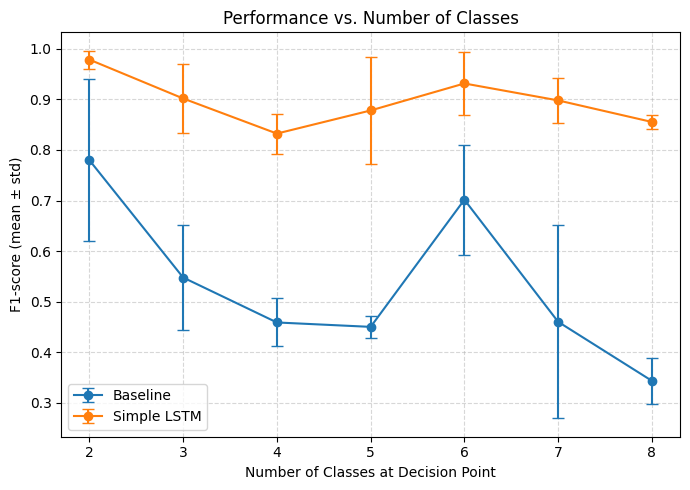

In [11]:
# --- 1. Get number of classes per decision point ---
num_classes_per_dp = (
    df_accuracy.groupby("decision_point")["label"]
    .nunique()
    .reset_index()
    .rename(columns={"label": "num_classes"})
)

# --- 2. Merge per-DP metrics with number of classes ---
dp_perf = pd.merge(
    dp_metrics_lstm.reset_index(),
    dp_metrics_baseline.reset_index(),
    on="decision_point",
    suffixes=("_lstm", "_baseline")
)
dp_perf = pd.merge(dp_perf, num_classes_per_dp, on="decision_point")

# --- 3. Convert percentage values to fraction scale ---
metric_cols = ["precision_lstm", "recall_lstm", "f1_score_lstm",
               "precision_baseline", "recall_baseline", "f1_score_baseline"]

for col in metric_cols:
    if dp_perf[col].max() > 1:  # Means it's in percentage
        dp_perf[col] = dp_perf[col] / 100.0

# --- 4. Group by num_classes and calculate mean & std (numeric only) ---
grouped = dp_perf.groupby("num_classes")[metric_cols].agg(["mean", "std"])

# --- 5. Plot Baseline vs LSTM F1-score with error bars ---
plt.figure(figsize=(7, 5))
plt.errorbar(
    grouped.index, grouped["f1_score_baseline"]["mean"],
    yerr=grouped["f1_score_baseline"]["std"],
    fmt='o-', capsize=4, label="Baseline"
)
plt.errorbar(
    grouped.index, grouped["f1_score_lstm"]["mean"],
    yerr=grouped["f1_score_lstm"]["std"],
    fmt='o-', capsize=4, label="Simple LSTM"
)

plt.xlabel("Number of Classes at Decision Point")
plt.ylabel("F1-score (mean ± std)")
plt.title("Performance vs. Number of Classes")
plt.xticks(grouped.index)  # Show exact class counts on x-axis
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

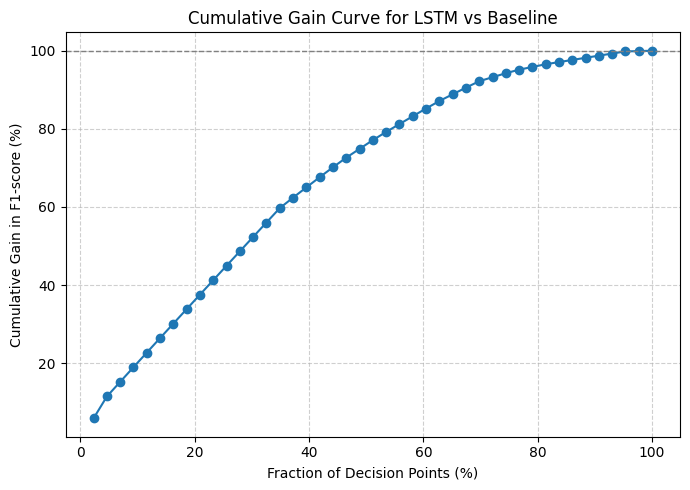

In [12]:
# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
).sort_values(ascending=False)

# --- 2. Compute cumulative sum (normalized to 100%) ---
cumulative_gain = dp_improvement.cumsum()
cumulative_gain_normalized = cumulative_gain / cumulative_gain.iloc[-1] * 100

# --- 3. X-axis: fraction of decision points ---
dp_fraction = np.arange(1, len(dp_improvement) + 1) / len(dp_improvement) * 100

# --- 4. Plot ---
plt.figure(figsize=(7, 5))
plt.plot(dp_fraction, cumulative_gain_normalized, marker="o")
plt.axhline(100, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Fraction of Decision Points (%)")
plt.ylabel("Cumulative Gain in F1-score (%)")
plt.title("Cumulative Gain Curve for LSTM vs Baseline")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


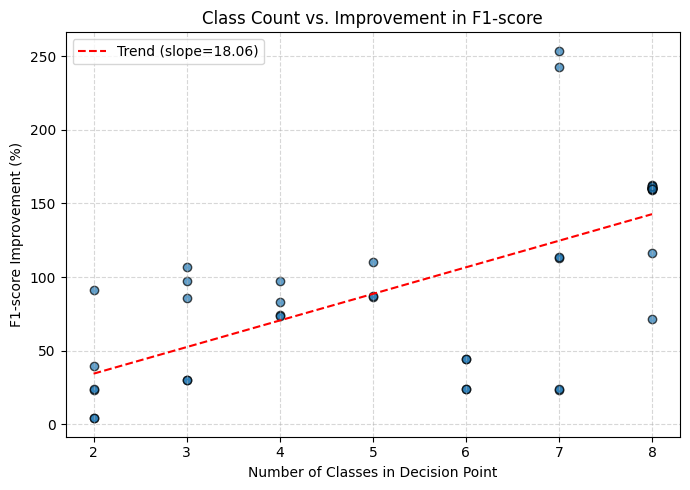

In [13]:
# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
)

# --- 2. Get number of classes per DP ---
num_classes_per_dp = df_accuracy.groupby("decision_point")["label"].nunique()

# Align with dp_improvement index
num_classes_per_dp = num_classes_per_dp.loc[dp_improvement.index]

# --- 3. Scatter plot ---
plt.figure(figsize=(7, 5))
plt.scatter(num_classes_per_dp, dp_improvement, alpha=0.7, edgecolor="black")

# --- 4. Fit regression line ---
coef = np.polyfit(num_classes_per_dp, dp_improvement, 1)
poly1d_fn = np.poly1d(coef)
x_vals = np.linspace(num_classes_per_dp.min(), num_classes_per_dp.max(), 100)
plt.plot(x_vals, poly1d_fn(x_vals), color="red", linestyle="--", label=f"Trend (slope={coef[0]:.2f})")

# --- 5. Labels & formatting ---
plt.xlabel("Number of Classes in Decision Point")
plt.ylabel("F1-score Improvement (%)")
plt.title("Class Count vs. Improvement in F1-score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## 1.6  Full Training and Storage

In [14]:
# --- Storage ---
accuracy_per_class = []
baseline_accuracy_per_class = []
decision_point_models_simple = {}

# --- Parameters ---
context_keys = ["case:LoanGoal", "case:ApplicationType", "case:RequestedAmount"]

# --- Loop through decision points ---
for decision_point in bpmn_decision_point_map:
    print(f"\n=== Training {decision_point} ===")

    try:
        # --- Load split datasets ---
        splits = dp_split_datasets_full_simple.get(decision_point)
        if not splits:
            print(f"No split data for {decision_point}")
            continue

        df_train = splits["train"]
        df_test = splits["test"]
        df_holdout = splits["holdout"]

        df_train_pool = pd.concat([df_train, df_test], ignore_index=True)
        n_pool = len(df_train_pool)

        # --- Prepare data ---
        df_lstm = pd.concat([df_train_pool, df_holdout], ignore_index=True)

        X_acts_padded, X_durs_padded, X_res_padded, activity_encoder, resource_encoder, label_encoder, y_all, max_seq_len = prepare_sequences_and_labels(df_lstm)

        # Add UNKNOWN class to encoders if missing
        if "UNKNOWN" not in resource_encoder.classes_:
            resource_encoder.classes_ = np.append(resource_encoder.classes_, "UNKNOWN")
        if "UNKNOWN" not in activity_encoder.classes_:
            activity_encoder.classes_ = np.append(activity_encoder.classes_, "UNKNOWN")

        # Prepare context attributes
        X_context_array, context_dim, context_encoders = prepare_context_attributes(df_lstm, context_keys)

        # Use train/test indexes to split padded input
        train_indices = list(range(0, n_pool))
        test_indices  = list(range(n_pool, n_pool + len(df_holdout)))

        X_acts_train, X_acts_test = X_acts_padded[train_indices], X_acts_padded[test_indices]
        X_durs_train, X_durs_test = X_durs_padded[train_indices], X_durs_padded[test_indices]
        X_res_train, X_res_test = X_res_padded[train_indices], X_res_padded[test_indices]
        X_context_train, X_context_test = X_context_array[train_indices], X_context_array[test_indices]
        y_train, y_test = y_all[train_indices], y_all[test_indices]

        # --- Build and train model ---
        model = build_lstm_model(
            num_activities=len(activity_encoder.classes_),
            num_resources=len(resource_encoder.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=len(label_encoder.classes_)
        )

        history = train_model(
            model,
            X_train=[X_acts_train, X_durs_train, X_res_train, X_context_train],
            y_train=y_train
        )

        # --- Evaluate ---
        y_pred_probs = model.predict([X_acts_test, X_durs_test, X_res_test, X_context_test])
        y_pred = np.argmax(y_pred_probs, axis=1)

        lstm_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_test, label_encoder)  # If using dist baseline now

        print(f"\n--- LSTM Model Results for {decision_point} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # Store results
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # Store trained model
        decision_point_models_simple[decision_point] = {
            "model": model,
            "activity_encoder": activity_encoder,
            "resource_encoder": resource_encoder,
            "label_encoder": label_encoder,
            "context_keys": context_keys,
            "context_encoders": context_encoders,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error while training {decision_point}: {e}")


=== Training DP 1 ===
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7697 - loss: 0.5102 - val_accuracy: 1.0000 - val_loss: 0.0526
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- LSTM Model Results for DP 1 ---
A_Concept: Precision=1.00, Recall=1.00, F1=1.00
A_Submitted: Precision=1.00, Recall=1.00, F1=1.00
W_Complete application: Precision=1.00, Recall=1.00, F1=1.00

=== Training DP 2 ===
No split data for DP 2

=== Training DP 3 ===
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9382 - loss:

In [15]:
# Go up from notebooks/ to project root, then into models/models_simple
save_dir = os.path.join("..", "models", "models_simple")
os.makedirs(save_dir, exist_ok=True)

for dp_name, data in decision_point_models_simple.items():
    dp_path = os.path.join(save_dir, dp_name)
    os.makedirs(dp_path, exist_ok=True)

    # Save model
    model_path = os.path.join(dp_path, "model.keras")
    data["model"].save(model_path)

    # Save encoders
    joblib.dump(data["activity_encoder"], os.path.join(dp_path, "activity_encoder.pkl"))
    joblib.dump(data["resource_encoder"], os.path.join(dp_path, "resource_encoder.pkl"))
    joblib.dump(data["label_encoder"], os.path.join(dp_path, "label_encoder.pkl"))
    joblib.dump(data["context_encoders"], os.path.join(dp_path, "context_encoders.pkl"))

    # Save metadata
    metadata = {
        "context_keys": data["context_keys"],
        "max_seq_len": data["max_seq_len"]
    }
    joblib.dump(metadata, os.path.join(dp_path, "metadata.pkl"))

print(f"Saved models to {os.path.abspath(save_dir)}")

Saved models to /Users/marcohmayer/Desktop/next_activity_prediction/models/models_simple
